In [1]:
from basic_utils import *
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from copy import deepcopy as copy
import cooler

DEBUG:matplotlib:CACHEDIR=/home/agalicina/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/agalicina/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
experiment_ids = "A9 B15 B19 B26 B3 B31 sc19 sc29 A2 A3 A5 A6 A8 B16 B6 sc1 sc16 sc21 sc23 sc24".split()
chrms = ['chr2L', 'chr3L', 'chr2R', 'chr3R', 'chrX']

labels_ordered = 'population merged A6 B31 A8 A5 sc23 B26 B19 B16 sc16 B3 A2 A3 sc1 B6 A9 sc24 sc29 sc19 sc21 B15'.split()

resolution = 10

## Subsampling merge

In [3]:
segmentations = {}
TADS_PATH = "../DATA/TAD_modularity_testing1/"
for l in labels_ordered[2:] + ['population', 'merged_cell']:
    name=l 
    if l=='population_mod':
        name='population'
    infile = os.path.join(TADS_PATH, "segmentation_{}_minTAD4_0.50.2Dannot".format(name))
    try:
        d = juice2D_to_segmentation(infile, resolution*1000, l)
        segmentations.update(d)
    except Exception as e:
        print(e)
        pass

## Let's create a nice set of parameters, this takes a contribution of efforts and investigation of what's actually happening with data

Retrieval of IS: 

in the folder COOL:

```
1024  cooltools diamond_insulation --balance Dros.10.cool.full 120000 > ../TMP/Dros_IS_balanced_10_120kb.tsv
1025  cooltools diamond_insulation --balance Dros.10.cool.full 80000 > ../TMP/Dros_IS_balanced_10_80kb.tsv
```

Retrieval of mappability:

In [8]:
# resolution = 10

# infile = "../DATA/COOL/Dros.10.cool.full"

# c = cooler.Cooler(infile)
# balance = False

# margins = {}
# for chrom1 in c.chromnames:
#     mtx = c.matrix(balance=balance).fetch(chrom1)
#     margins[chrom1] = np.zeros(len(mtx))
#     for chrom2 in c.chromnames:
#         mtx = c.matrix(balance=balance).fetch(chrom1, chrom2)
#         if chrom1==chrom2:
#             margins[chrom1] += np.triu(mtx).sum(axis=1)
#         else:
#             margins[chrom1] += mtx.sum(axis=1)
            
            
# outfile = "../DATA/TMP/Dros_mappability_10kb_raw.bed"
# res = 10000
# with open(outfile, 'w') as outf:
#     for ch in list(margins.keys()):
#         for i in range(len(margins[ch])):
#             s = '{}\t{}\t{}\t{:.0f}\n'.format(ch, i*res, i*res+res, margins[ch][i])
#             outf.write(s)

In [9]:
# resolution = 10

# infile = "../DATA/COOL/merged_cell.10.cool"

# c = cooler.Cooler(infile)
# balance = False

# margins = {}
# for chrom1 in c.chromnames:
#     mtx = c.matrix(balance=balance).fetch(chrom1)
#     margins[chrom1] = np.zeros(len(mtx))
#     for chrom2 in c.chromnames:
#         mtx = c.matrix(balance=balance).fetch(chrom1, chrom2)
#         if chrom1==chrom2:
#             margins[chrom1] += np.triu(mtx).sum(axis=1)
#         else:
#             margins[chrom1] += mtx.sum(axis=1)
            
            
# outfile = "../DATA/TMP/merged_mappability_10kb_raw.bed"
# res = 10000
# with open(outfile, 'w') as outf:
#     for ch in list(margins.keys()):
#         for i in range(len(margins[ch])):
#             s = '{}\t{}\t{}\t{:.0f}\n'.format(ch, i*res, i*res+res, margins[ch][i])
#             outf.write(s)

In [6]:
# Quality control

df_m1 = pd.read_csv("../DATA/TMP/merged_mappability_10kb_raw.bed", sep='\t', header=None)
df_m1.columns = ['ch', 'bgn', 'end', 'merged_map']
df_m2 = pd.read_csv("../DATA/TMP/Dros_mappability_10kb_raw.bed", sep='\t', header=None)
df_m2.columns = ['ch', 'bgn', 'end', 'dros_map']
df_is = pd.read_csv("../DATA/TMP/Dros_IS_balanced_10_100kb.bed", sep=' ', header=None)
df_is.columns = ['ch', 'bgn', 'end', 'is']

df_m = pd.merge(df_m1, df_m2, on=['ch', 'bgn', 'end'])
df_m = pd.merge(df_m,  df_is, on=['ch', 'bgn', 'end'])

<Figure size 504x504 with 0 Axes>

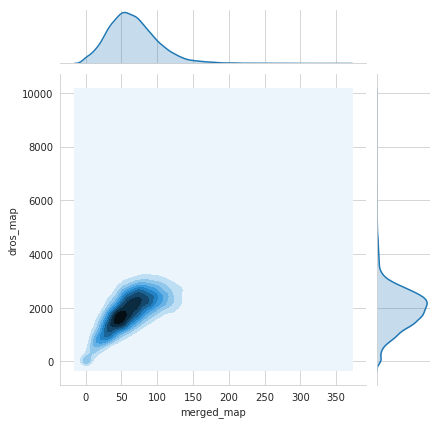

In [7]:
plt.figure(figsize=[7,7])
sns.jointplot(data=df_m, x='merged_map', y='dros_map', kind="kde")

<Figure size 504x504 with 0 Axes>

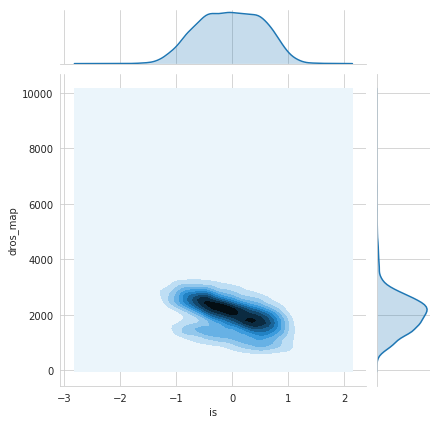

In [8]:
plt.figure(figsize=[7,7])
sns.jointplot(data=df_m, x='is', y='dros_map', kind="kde")

<Figure size 504x504 with 0 Axes>

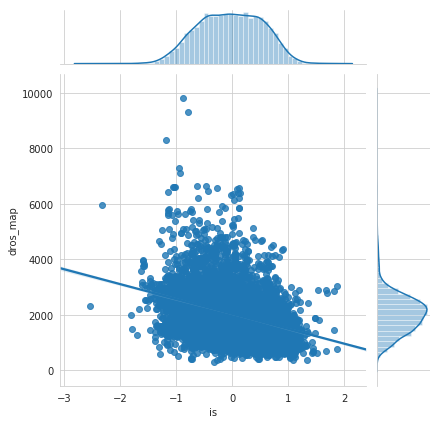

In [9]:
plt.figure(figsize=[7,7])
sns.jointplot(data=df_m, x='is', y='dros_map', kind="reg")

### Reading tracks

Let's create dataframe with all tracks

In [216]:
categories = ['stable', 'nearly_stable', 'nearly_nonstable', 'nonstable', 'population', 'merged', 'randomized']
keys_mod = ['A6', 'B31', 'A8', 'A5', 'sc23', 'B26', 'B19', 'B16', 'sc16', 'B3', 'A2', 'A3', 'sc1', 'B6', 'A9', 'sc24', 'sc29', 'sc19', 'sc21', 'B15']


In [218]:
WD_TRACKS = "../DATA/ANNOT/ML-DmBG3_10K/"
annot = open("../DATA/ANNOT/ML-DmBG3.names", 'r').readlines()
annot = dict([[y.strip() for y in x.split(' - ')] for x in annot])
annot1 = {x: annot[x].split('/')[-1].split(':')[0] for x in annot.keys()}
annot1.update({'rnaseq1': 'BG3 RNA-Seq', 
               'rnaseq2': 'BG3 RNA-Seq', 
              'housekeeping': 'housekeeping',
              'tissue-spec-BG3exp': 'tissue-spec-BG3exp',
              'tissue-spec-BG3noexp': 'tissue-spec-BG3noexp',
              'tss': 'tss',
               'tes':'tes',
              'all_genes': 'all_genes',
              'mappability_pop': 'mappability_pop',
              'mappability_merged': 'mappability_merged',
              'is120': 'is120',
              'is100': 'is100',
              'is80': 'is80'
              })

import glob
fs = glob.glob(WD_TRACKS+"*.binned")
f_dict = {x.split("-")[-1].split('.')[0]:x for x in fs if 'merged' not in x}
f_dict.update({'rnaseq1': '../DATA/ANNOT/ML-DmBG3-RNAseq/BG3-110K.binned', 
               'rnaseq2': '../DATA/ANNOT/ML-DmBG3-RNAseq/BG3-210K.binned',
              'housekeeping': '../DATA/ANNOT/GENES/housekeeping_10K.cov.bedgraph',
              'tissue-spec-BG3exp': '../DATA/ANNOT/GENES/tissuespecBG3exp_10K.cov.bedgraph',
              'tissue-spec-BG3noexp': '../DATA/ANNOT/GENES/tissuespecBG3noexp_10K.cov.bedgraph',
              'tss': '../DATA/ANNOT/GENES/allgenestss_10K.cov.bedgraph',
              'tes': '../DATA/ANNOT/GENES/allgenestes_10K.cov.bedgraph',
              'all_genes': '../DATA/ANNOT/GENES/allgenes_10K.cov.bedgraph',
              'mappability_pop': '../DATA/TMP/Dros_mappability_10kb_raw.bed',
              'mappability_merged': '../DATA/TMP/merged_mappability_10kb_raw.bed',
              'is100':'../DATA/TMP/Dros_IS_balanced_10_100kb.bed',
              'is120':'../DATA/TMP/Dros_IS_balanced_10_120kb.bed',
              'is80':'../DATA/TMP/Dros_IS_balanced_10_80kb.bed'
              })

for x in categories:
    f_dict.update({'boundary_{}'.format(x): '../DATA/ANNOT/complex_boundaries_{}.cov.bed'.format(x)})
    annot1.update({'boundary_{}'.format(x): 'boundary_{}'.format(x)})

f_dict.update({'subsampling_support': '../DATA_SUBSAMPLE/borders_subsample_stability.bedgraph'})
annot1.update({'subsampling_support': 'subsampling_support'})

import operator
ks = [x[0] for x in sorted(annot1.items(), key=operator.itemgetter(1))]


## All selected for genome research
selected_tracks = ['rnaseq1', 'rnaseq2', 'housekeeping', 'tissue-spec-BG3exp', 'tissue-spec-BG3noexp',
                   'tss', 'tes', 'all_genes', 'mappability_pop', 'mappability_merged', 'is80', 'is120', 'is100',
                   '105', '112', '113', '114', '129', '132', '155', '171', '174',
                   '192', '21', '217', '220', '225', '228', '232', '235', '238',
                   '241', '244', '247', '250', '253', '268', '290', '293', '296',
                   '299', '30', '39', '48', '51', '54', '57', '63', '83', '86', '92']
for x in categories:
    selected_tracks.append('boundary_{}'.format(x))
selected_tracks.append('subsampling_support')

In [12]:
df = pd.DataFrame()
for l in selected_tracks:
    infile = f_dict[l]
    df_tmp = pd.read_csv(infile, sep='\s*')
    name = "{}_{}".format(l, annot1[l]) if l!=annot1[l] else l
    if len(df_tmp.columns) == 3:
        df_tmp.columns = ['ch', 'pos', name]
    else:
        df_tmp.columns = ['ch', 'pos', 'end', name]
        df_tmp = df_tmp.drop('end', axis=1)
        
    if len(df)==0:
        df = df_tmp.copy()
    else:
        df = pd.merge(df, df_tmp, on=['ch', 'pos'])

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


### Reading TADs

In [13]:
experiment_ids = "A9 B15 B19 B26 B3 B31 sc19 sc29 A2 A3 A5 A6 A8 B16 B6 sc1 sc16 sc21 sc23 sc24".split()
chrms = ['chr2L', 'chr3L', 'chr2R', 'chr3R', 'chrX']

labels_ordered = 'population merged A6 B31 A8 A5 sc23 B26 B19 B16 sc16 B3 A2 A3 sc1 B6 A9 sc24 sc29 sc19 sc21 B15'.split()


resolution = 10
segmentations = {}
TADS_PATH = "../DATA/TAD_modularity_testing1/"
for l in labels_ordered[2:] + ['population', 'merged_cell']:
    name=l 
    if l=='population_mod':
        name='population'
    infile = os.path.join(TADS_PATH, "segmentation_{}_minTAD4_0.50.2Dannot".format(name))
    try:
        d = juice2D_to_segmentation(infile, resolution*1000, l)
        segmentations.update(d)
        #segmentations[l] = pickle.load(open(infile, 'rb'))
    except Exception as e:
        print(e)
        pass

### Converting TADs to df

In [14]:
def define_stable(x, 
                  categories=['nonstable', 'nearly_nonstable', 'nearly_stable', 'stable'], 
                  control_points=[0.25, 0.5, 0.75]):
    
    for i, pt in enumerate(control_points):
        if x<=pt:
            return categories[i], "{}_{}".format(i, categories[i])
    return categories[-1], "{}_{}".format(len(categories)-1, categories[-1])

In [15]:
def return_centers_of_regions(df, col):
    v = []
    n=0
    df = df.reset_index(drop=True).copy()
    for i, r in df.iterrows():
        if i==0:
            r_prev = r.copy()
            v.append(n)
            continue
        if r[col]!=r_prev[col] or r.ch!=r_prev.ch:# or r.exp!=r_prev.exp:
            n+=1
        v.append(n)
        r_prev = r.copy()

    df['grouped'] = v
    df1 = df.groupby('grouped').apply(lambda tmp: tmp.loc[min(tmp.index)+(max(tmp.index)-min(tmp.index))//2, :] )
    return df1

In [16]:
df_all = segmentation2df(segmentations, resolution=10000, offset=1)

In [17]:
regime = 'boundary_mod' # boundary or tad

keys = keys_den if 'den' in regime else keys_mod
coi = 'is_boundary' if 'boundary' in regime else 'is_tad'
reference = 'population_den' if 'den' in regime else 'population'
reference_merged = 'merged_den' if 'den' in regime else 'merged_cell'

In [18]:
segmentations_additional = {}
segmentations_additional['population'] = segmentations[reference]
segmentations_additional['merged']     = segmentations[reference_merged]
segmentations_additional['randomized'] = {k:shuffle_segmentation(segmentations[reference][k]).copy() for k in chrms}

df_additional = segmentation2df(segmentations_additional, resolution=10000, offset=1)

In [19]:
res_chip = 10000
df_additional = return_centers_of_regions(df_additional, coi).query('{}==1'.format(coi))
df_additional['label'] = df_additional['exp']
df_additional['chr_sh']  = df_additional.apply(lambda x: x.ch[3:], axis=1)
df_additional['pos'] = df_additional['bgn']
df_additional['pos_bin'] = df_additional['bgn']//res_chip

In [20]:
df_cells = df_all.query("exp in {}".format(keys))
ncells = len(keys)

df_gr = df_cells.groupby(['ch', 'pos']).aggregate({coi:sum, 'bgn':'first', 'end':'first'}).reset_index()
df_gr.loc[:, 'complex'] = df_gr[coi]/ncells
df_gr = df_gr.drop(coi, axis=1)

In [18]:
np.sum(df_gr.complex<=0)

184

[0.1, 0.3, 0.65]


(0, 1)

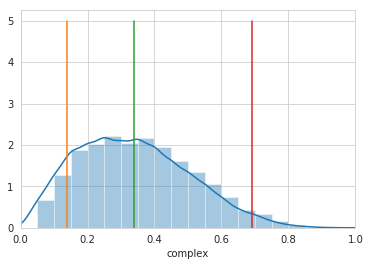

In [19]:
categories = ['never', 'nonstable', 'nearly_nonstable', 'nearly_stable', 'stable']
control_points = [np.percentile(df_gr[df_gr.complex>0].complex, x) for x in [5, 50, 95]]
print(control_points)

f = sns.distplot(df_gr[df_gr.complex>0].complex, bins=np.arange(0-0.0001, 1.05, 0.05))
for i in control_points:
    plt.plot([i+0.04, i+0.04],[0,5])
plt.xlim([0,1])

In [20]:
df_gr.loc[:, 'pos'] = df_gr.loc[:, 'bgn']

df_gr.loc[:, 'label_true'] = df_gr.complex.apply(
    lambda x: define_stable(x, [0, 1, 2, 3, 4], [0.0001]+control_points)[0])
df_gr.loc[:, 'stability_state'] = df_gr.complex.apply(
    lambda x: define_stable(x, categories, [0.0001]+control_points)[1])

df_gr = df_gr.drop(['bgn','end'], axis=1)


df_gr['chr_sh']  = df_gr.apply(lambda x: x.ch[3:], axis=1)
df_gr['pos_bin'] = df_gr['pos']//res_chip

df = pd.merge(df, df_gr, on=['ch', 'pos'])

In [22]:
df.to_csv("../DATA_SUBSAMPLE/full_boundary_annotation_table.csv")

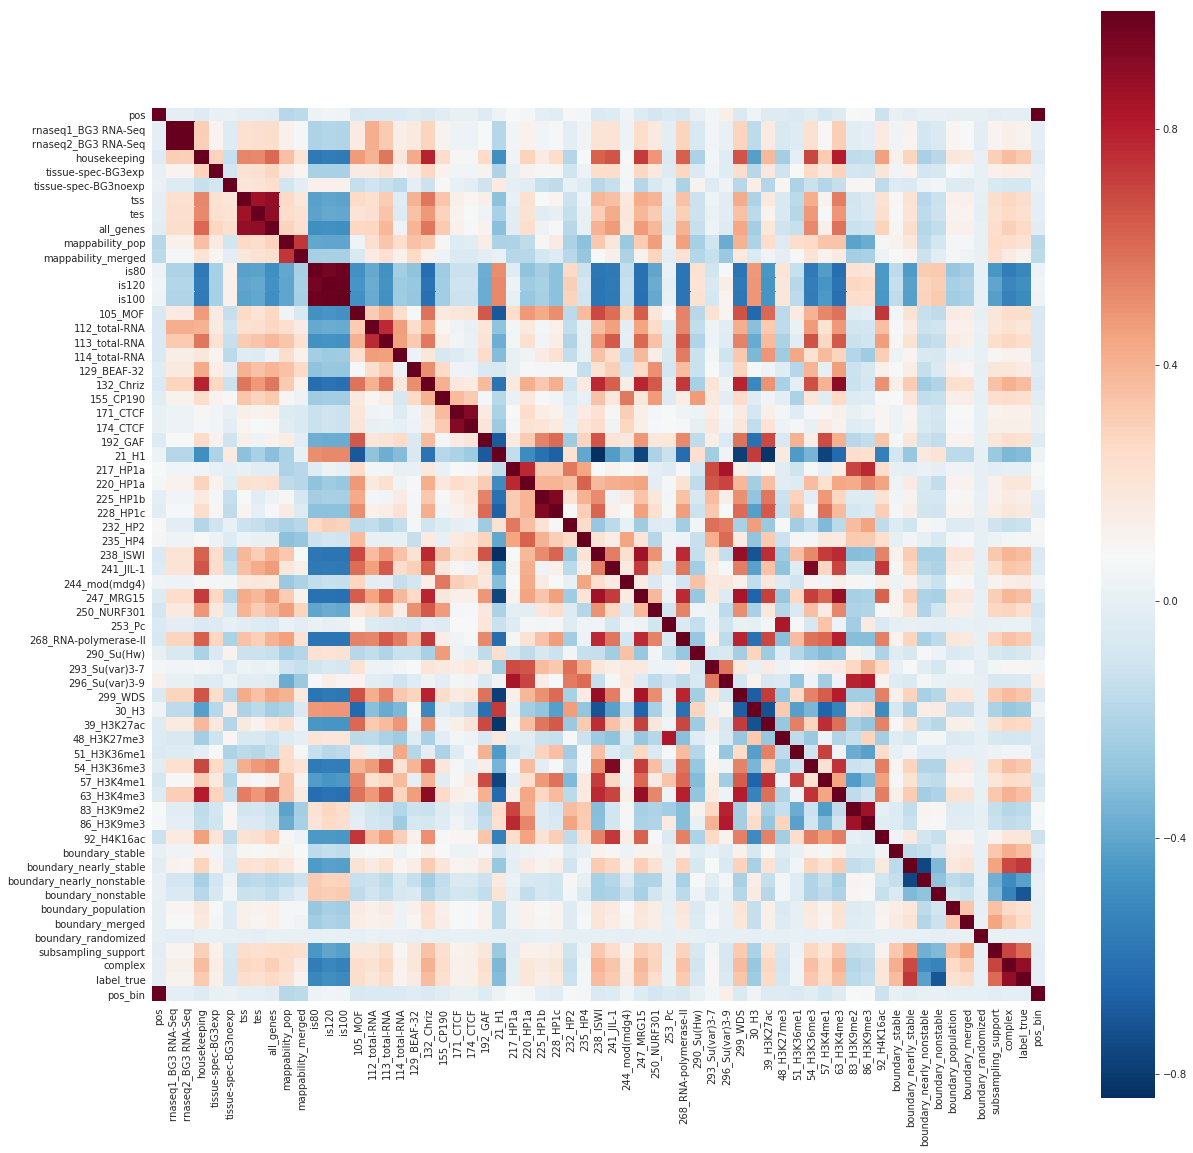

In [23]:
plt.figure(figsize=[20,20])
sns.heatmap(df.corr(), cmap='RdBu_r', square=True)

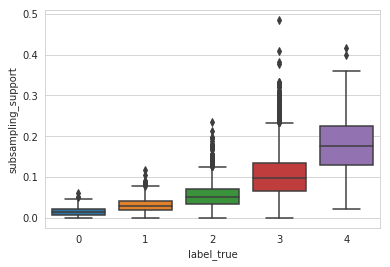

In [24]:
sns.boxplot(data=df, x='label_true', y='subsampling_support')

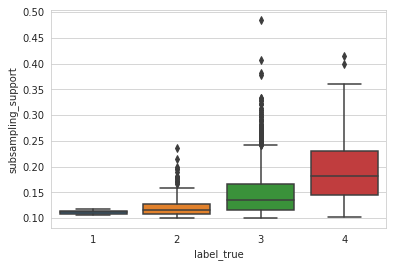

In [26]:
sns.boxplot(data=df.query("subsampling_support>0.1"), x='label_true', y='subsampling_support')

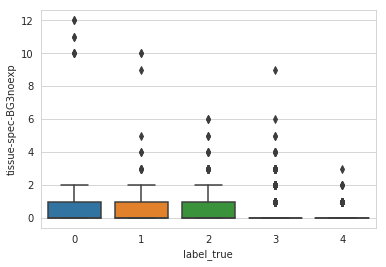

In [123]:
sns.boxplot(data=df, x='label_true', y='tissue-spec-BG3noexp')

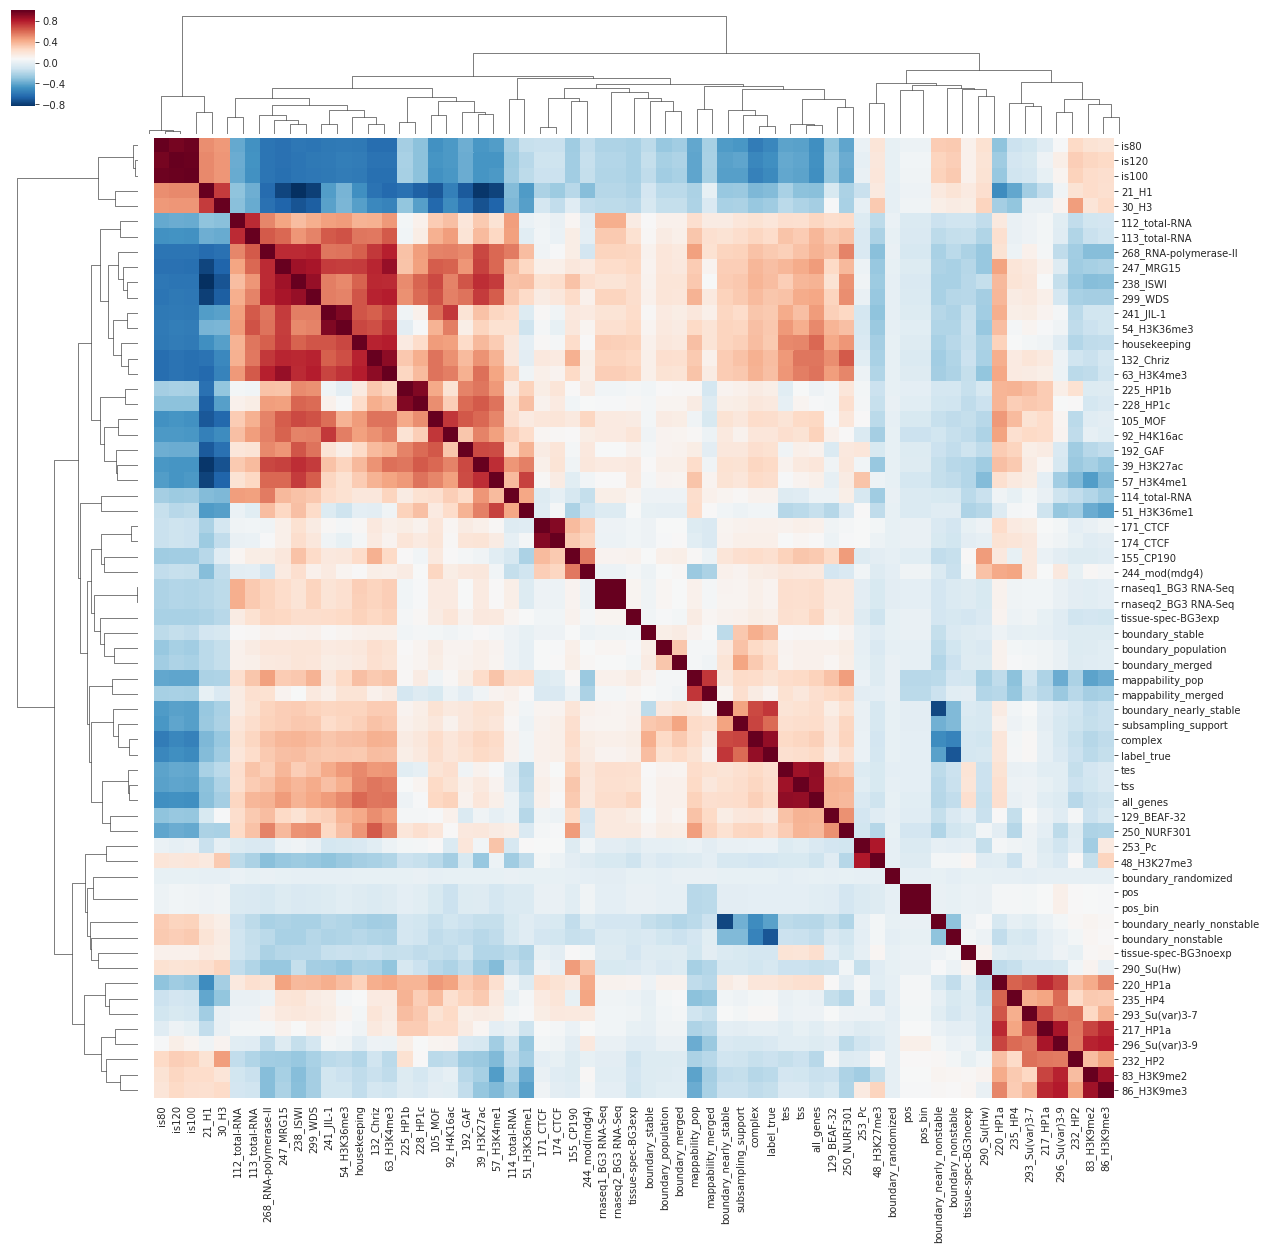

In [27]:
sns.clustermap(df.corr(), cmap='RdBu_r', square=True, figsize=[20,20])

In [ ]:
#sns.pairplot(df)

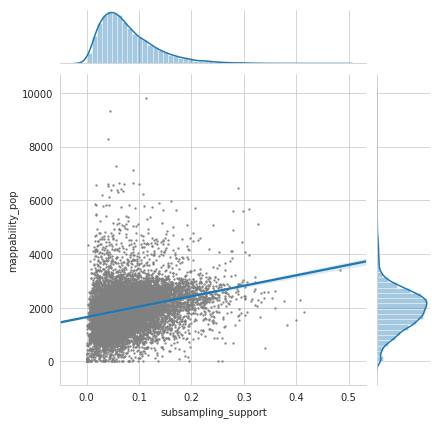

In [33]:
sns.jointplot(data=df, x='subsampling_support', y='mappability_pop', 
              kind='reg', joint_kws={"scatter_kws": {"s": 2, 'color':'gray'}})

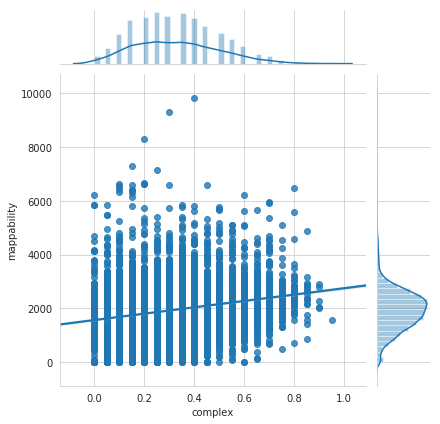

In [155]:
sns.jointplot(data=df, x='complex', y='mappability', kind='reg')

In [22]:
# df_merged = pd.merge(df_gr, df_all.query("exp=='{}'".format(reference)), on=['ch', 'bgn'], suffixes=['_gr', '_pop'] ) 

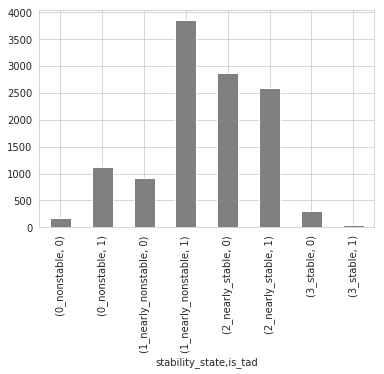

In [23]:
# df_merged.groupby(['stability_state', 'is_tad']).count()['ch'].plot(kind='bar', color='gray')

In [39]:
np.unique(list(annot1.values()))

array(['5-prime-UTR', 'ASH-1', 'BEAF-32', 'BG3 RNA-Seq', 'CP190', 'CTCF',
       'Chriz', 'Enhancer-of-zeste', 'GAF', 'H1', 'H2Av', 'H2Bubi', 'H3',
       'H3K18ac', 'H3K23ac', 'H3K27ac', 'H3K27me1', 'H3K27me2',
       'H3K27me3', 'H3K36me1', 'H3K36me3', 'H3K4me1', 'H3K4me2',
       'H3K4me3', 'H3K79me1', 'H3K79me2', 'H3K79me3', 'H3K9acS10P',
       'H3K9me2', 'H3K9me3', 'H4', 'H4K16ac', 'H4K20me1', 'H4K8ac',
       'HP1a', 'HP1b', 'HP1c', 'HP2', 'HP4', 'ISWI', 'JHDM1', 'JIL-1',
       'MOF', 'MRG15', 'NURF301', 'ORC2', 'PCL', 'POF', 'PR-Set7', 'Pc',
       'Psc', 'RNA-polymerase-II', 'RPD3', 'Replication-Copy-Number',
       'Replication-Origin', 'Replication-Timing', 'Su(Hw)', 'Su(var)3-7',
       'Su(var)3-9', 'WDS', 'ZW5', 'all_genes', 'boundary_merged',
       'boundary_nearly_nonstable', 'boundary_nearly_stable',
       'boundary_nonstable', 'boundary_population', 'boundary_randomized',
       'boundary_stable', 'dRING', 'dSFMBT', 'dmTopo-II', 'housekeeping',
       'is100', 'is1

In [25]:
# accepted_marks = np.unique([annot1[x] for x in selected_tracks])

In [26]:
# #accepted_marks = ['CTCF', 'H1', 'Pc', 'H3K27me3', 'tss', 'tes', 'all_genes',
# #       'housekeeping', 'tissue-spec-BG3exp', 'tissue-spec-BG3noexp', 
# #                  'BG3 RNA-Seq', 'total-RNA', 'RNA-polymerase-II']
# #
# categories = ['stable', 'nearly_stable', 'nearly_nonstable', 'nonstable', 'population', 'merged', 'randomized']

# #for x in categories:
# #    accepted_marks.append('boundary_{}'.format(x))

In [27]:
# df_gr1 = return_centers_of_regions(df_gr, 'stability_state')
# df_gr1 = df_gr1.groupby(['ch', 'pos_bin']).filter(lambda x: x.count()['bgn']==1 )

In [28]:
# accepted_marks = [x for x in accepted_marks if 'boundary' not in x]

In [29]:
# df_toplot = pd.concat([df_gr1, df_additional]).reset_index(drop=True).infer_objects()

# nrows = len(accepted_marks) #np.unique(list(annot1.values())))

# categories = ['stable', 'nearly_stable', 'nearly_nonstable', 
#               'nonstable', 'population', 'merged']
# ncols = len(categories)

# for_abs_count = ['tss', 'tes', 'all_genes', 'housekeeping', 
#                  'tissue-spec-BG3exp', 'tissue-spec-BG3noexp']

# for x in categories:
#     for_abs_count.append('boundary_{}'.format(x))
    
# rng = 0

# df_res = pd.DataFrame(df_toplot.loc[:, ['ch', 'pos_bin', 'label', 'zvalue']].copy())

# for num in selected_tracks:
#         lab = annot1[num]
#         if not lab in accepted_marks:
#             continue

#         df_chip = pd.read_csv(f_dict[num], 
#                          sep='\s', header=None)
        
#         if len(df_chip.columns)==3:
#             df_chip.columns = ['ch', 'pos', 'value']
#         else:
#             df_chip.columns = ['ch', 'pos', 'end', 'value']
            
#         df_chip['chr_sh'] = df_chip.apply(lambda x: x.ch[3:], axis=1)
#         df_chip['pos_bin'] = df_chip['pos']//res_chip
#         if not lab in for_abs_count:
#             df_chip['zvalue'] = scipy.stats.zscore(df_chip['value'])
#         else:
#             df_chip['zvalue'] = df_chip['value'].copy()
            
#         df_tmp = pd.merge(df_res, df_chip, 
#                           on=['ch', 'pos_bin'], 
#                           suffixes=['_boundary', '_annot']).loc[:,['ch', 'pos_bin', 'label', 'zvalue_annot']]
#         df_tmp = df_tmp.rename(index=str, columns={"zvalue_annot": lab+'_'+num})
#         df_res = pd.merge(df_res, df_tmp, on=['ch', 'label', 'pos_bin'])

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine

In [30]:
#df = df_res.copy()
#df = df.drop(['zvalue'], axis=1).dropna()

In [44]:
predictors_names = ['rnaseq1_BG3 RNA-Seq', 'rnaseq2_BG3 RNA-Seq',
                    '112_total-RNA', '113_total-RNA', '114_total-RNA', 
                    'housekeeping', 'tissue-spec-BG3exp', 'tissue-spec-BG3noexp', 'tss',
                    'tes', 'all_genes', 'mappability_pop', 'mappability_merged', 
                    'is80', 'is120', 'is100', 
                     'subsampling_support',
                    '105_MOF', 
                    '129_BEAF-32', '132_Chriz', '155_CP190', '171_CTCF',
                    '174_CTCF', '192_GAF', '21_H1', '217_HP1a', '220_HP1a', '225_HP1b',
                    '228_HP1c', '232_HP2', '235_HP4', '238_ISWI', '241_JIL-1',
                    '244_mod(mdg4)', '247_MRG15', '250_NURF301', '253_Pc',
                    '268_RNA-polymerase-II', '290_Su(Hw)', '293_Su(var)3-7',
                    '296_Su(var)3-9', '299_WDS', '30_H3', '39_H3K27ac', '48_H3K27me3',
                    '51_H3K36me1', '54_H3K36me3', '57_H3K4me1', '63_H3K4me3', '83_H3K9me2',
                    '86_H3K9me3', '92_H4K16ac']

output_name = 'label_true'

In [55]:
df = df.dropna()

In [56]:
X = df.loc[:,predictors_names].values
y_true = df.loc[:,output_name].values

In [49]:
import scipy
from sklearn import decomposition
from sklearn import manifold

In [36]:
nk = 7

In [57]:
Z = scipy.cluster.hierarchy.linkage(X, method='single', metric='correlation')
labels_h = scipy.cluster.hierarchy.fcluster(Z, nk, criterion='maxclust')-1
#df.loc[:,'y_hclust'] = labels_h

In [58]:
centroids, labels = scipy.cluster.vq.kmeans2(X, nk, iter=10, minit='points')
#df.loc[:,'y_kmeans'] = labels

pca = decomposition.PCA(n_components=4)
X_tr_pca = pca.fit(X).transform(X)

plt.plot(pca.explained_variance_ratio_)

In [64]:
pca = decomposition.PCA(n_components=4)
X_tr_pca = pca.fit(X).transform(X)

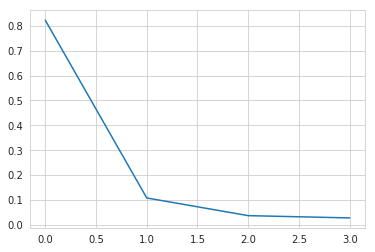

In [60]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
# todo: finish this section

In [93]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import EllipseCollection

def plot_corr_ellipses(data, pv=None, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

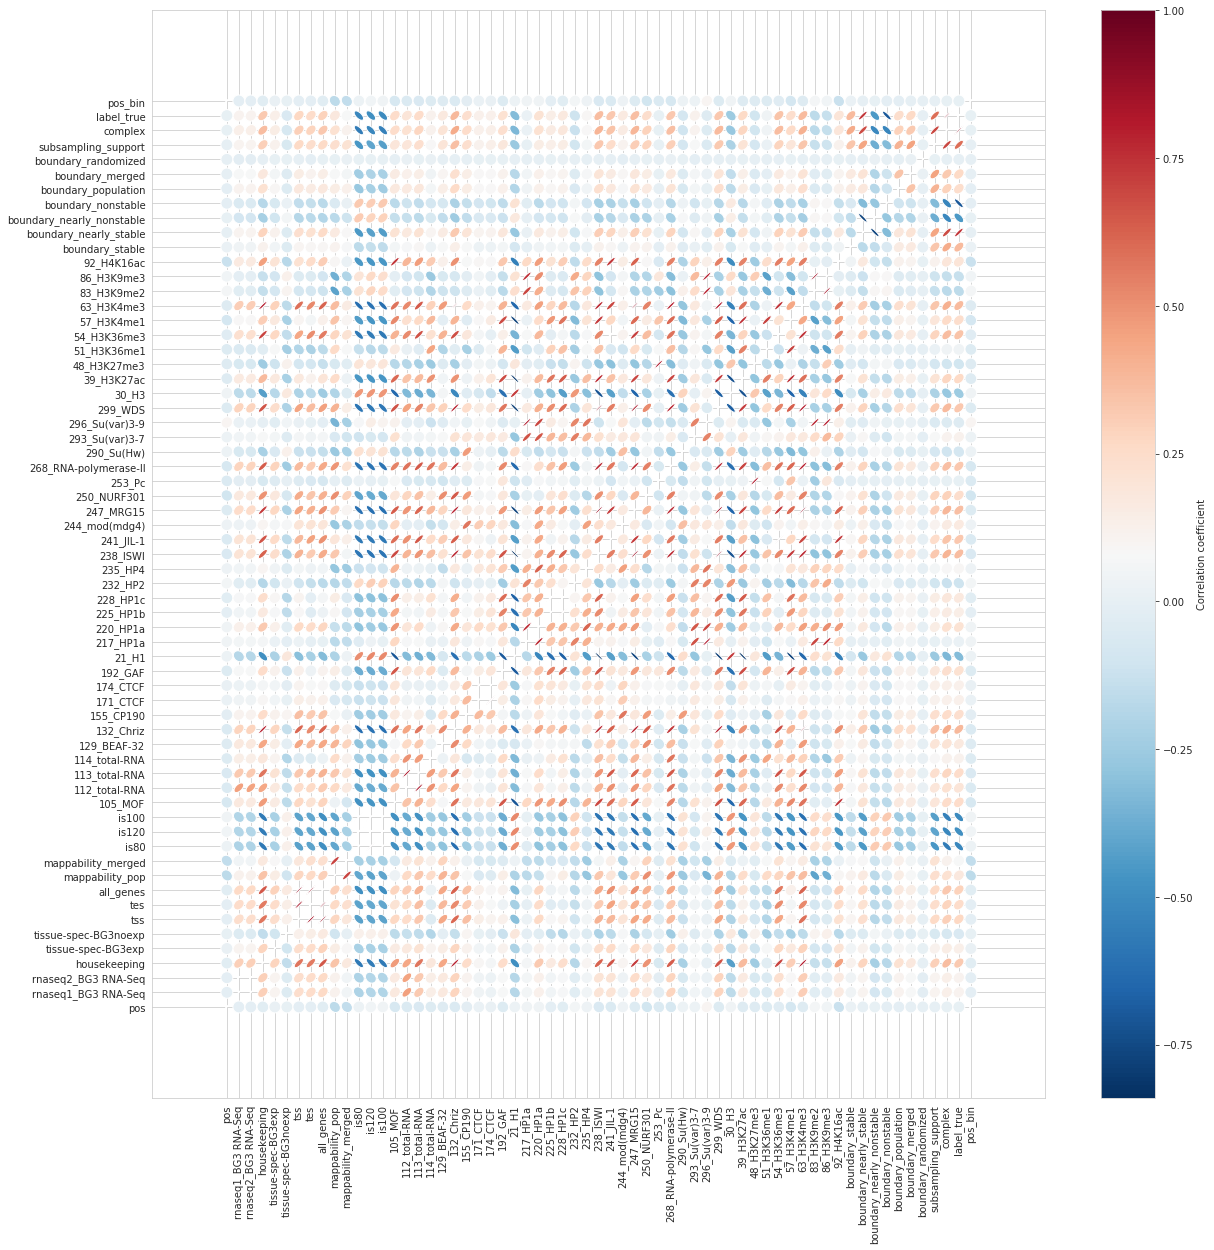

In [97]:
data = df.corr()
fig, ax = plt.subplots(1, 1, figsize=[20,20])
m = plot_corr_ellipses(data, ax=ax, cmap='RdBu_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)

In [98]:
corr = df.loc[:,predictors_names].apply(lambda x: scipy.stats.pearsonr(x.values, X_tr_pca[:,0])[0], axis=0)

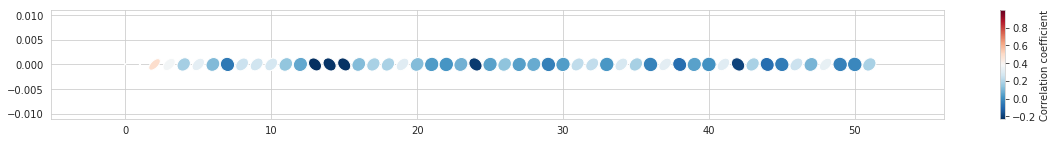

In [102]:
fig, ax = plt.subplots(1, 1, figsize=[20,2])
m = plot_corr_ellipses([corr], ax=ax, cmap='RdBu_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)

In [38]:
# tsne = manifold.TSNE(n_components=2)
# values_tr_tsne = tsne.fit_transform(values)

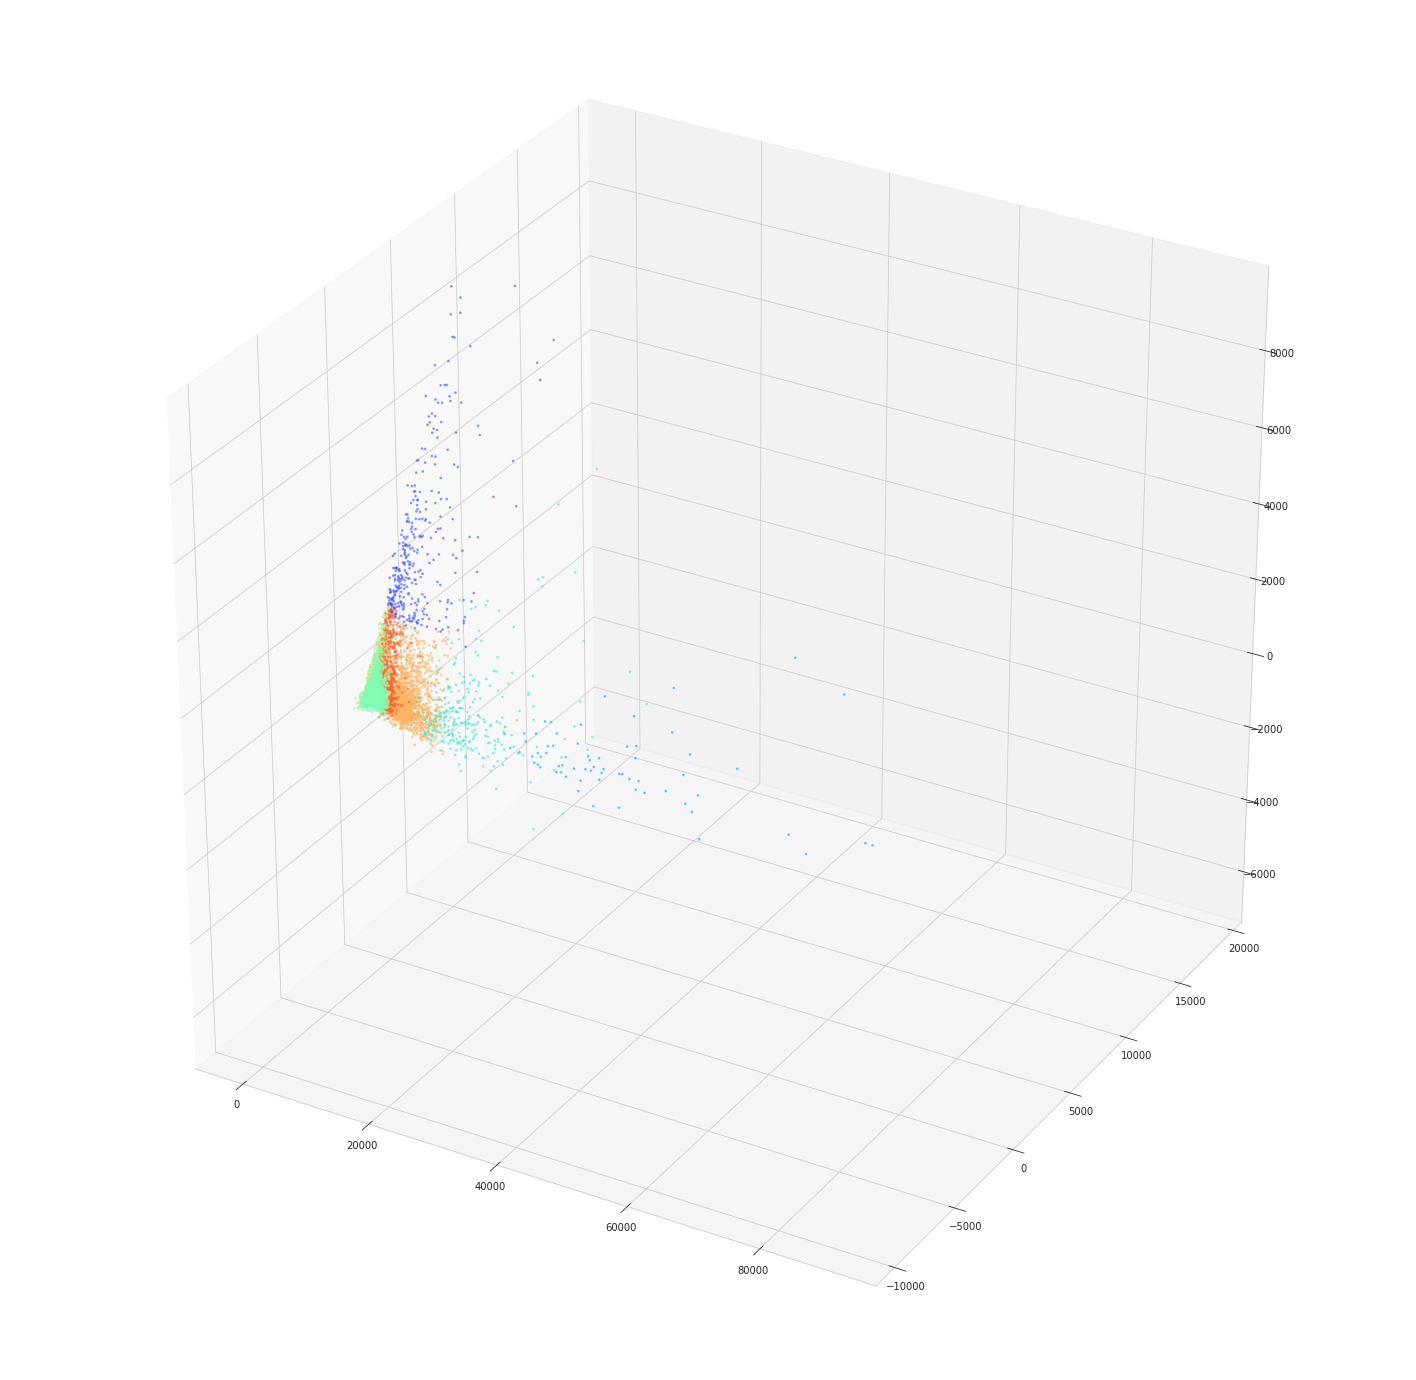

In [65]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[25,25])
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('rainbow_r', nk)#['red', 'green', 'blue', 'black', 'yellow']
for l in range(nk):
    idx = labels==l
    ax.scatter(X_tr_pca[idx,0], X_tr_pca[idx,1], X_tr_pca[idx,2], alpha=0.5, s=3, color=colors[l])

In [62]:
from sklearn.preprocessing import LabelEncoder

In [42]:
lb_make = LabelEncoder()
df.loc[:, 'label_encoded'] = lb_make.fit_transform(df_res['label'])

In [43]:
lb_make.classes_

array(['merged', 'nearly_nonstable', 'nearly_stable', 'nonstable',
       'population', 'randomized', 'stable'], dtype=object)

In [44]:
labels_true = df.loc[:, 'label_encoded']

In [45]:
np.bincount(labels_true)

array([1243, 1859, 1624,  584, 1278, 1278,  240])

In [261]:
contingeny_table = pd.crosstab(labels, df_res['label'])
contingeny_table

label  merged  nearly_nonstable  nearly_stable  nonstable  population  \
row_0                                                                   
0          27                93             64         50          26   
1          17                68             28         24          12   
2         222               265            280         48         222   
3         183               758            351        319         201   
4         233               222            329         37         224   
5         340               128            315         10         368   
6         221               325            257         96         225   

label  randomized  stable  
row_0                      
0              65       6  
1              22       2  
2             175      47  
3             447      28  
4             200      51  
5             172      84  
6             196      22

In [262]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(contingeny_table, correction=False)
p

1.6301696132495006e-214

In [263]:
labels_true = df.loc[:, 'label_encoded']

In [61]:
lb_make.classes_

NameError: name 'lb_make' is not defined

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/

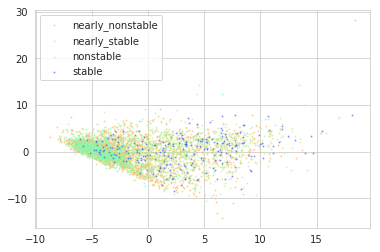

In [54]:
plt.plot(figsize=[15,15])
colors = sns.color_palette('rainbow_r', nk) #['red', 'green', 'blue', 'black', 'yellow']
for l in [1,2,3,6]: #np.unique(labels_true): #range(nk):
    idx = labels_true==l
    name = lb_make.inverse_transform(l)
    plt.scatter(X_tr_pca[idx,0], X_tr_pca[idx,1], alpha=0.5, s=1, color=colors[l], label=name)
plt.legend()

In [264]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [265]:
X = values
y = labels_true

clf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [266]:
df.loc[:,'y_rf'] = clf.predict(X)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 46 Text xticklabel objects>)

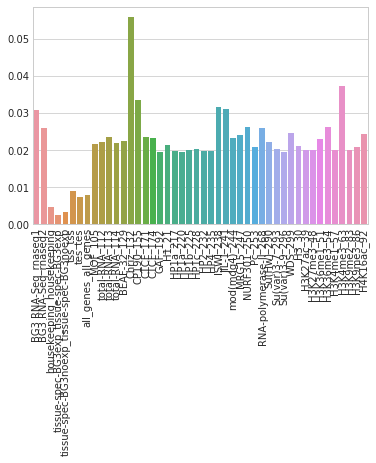

In [267]:
sns.barplot(x=feature_names, y=clf.feature_importances_)
plt.xticks(rotation=90)

In [300]:
df = df.join( pd.get_dummies(df.label) )

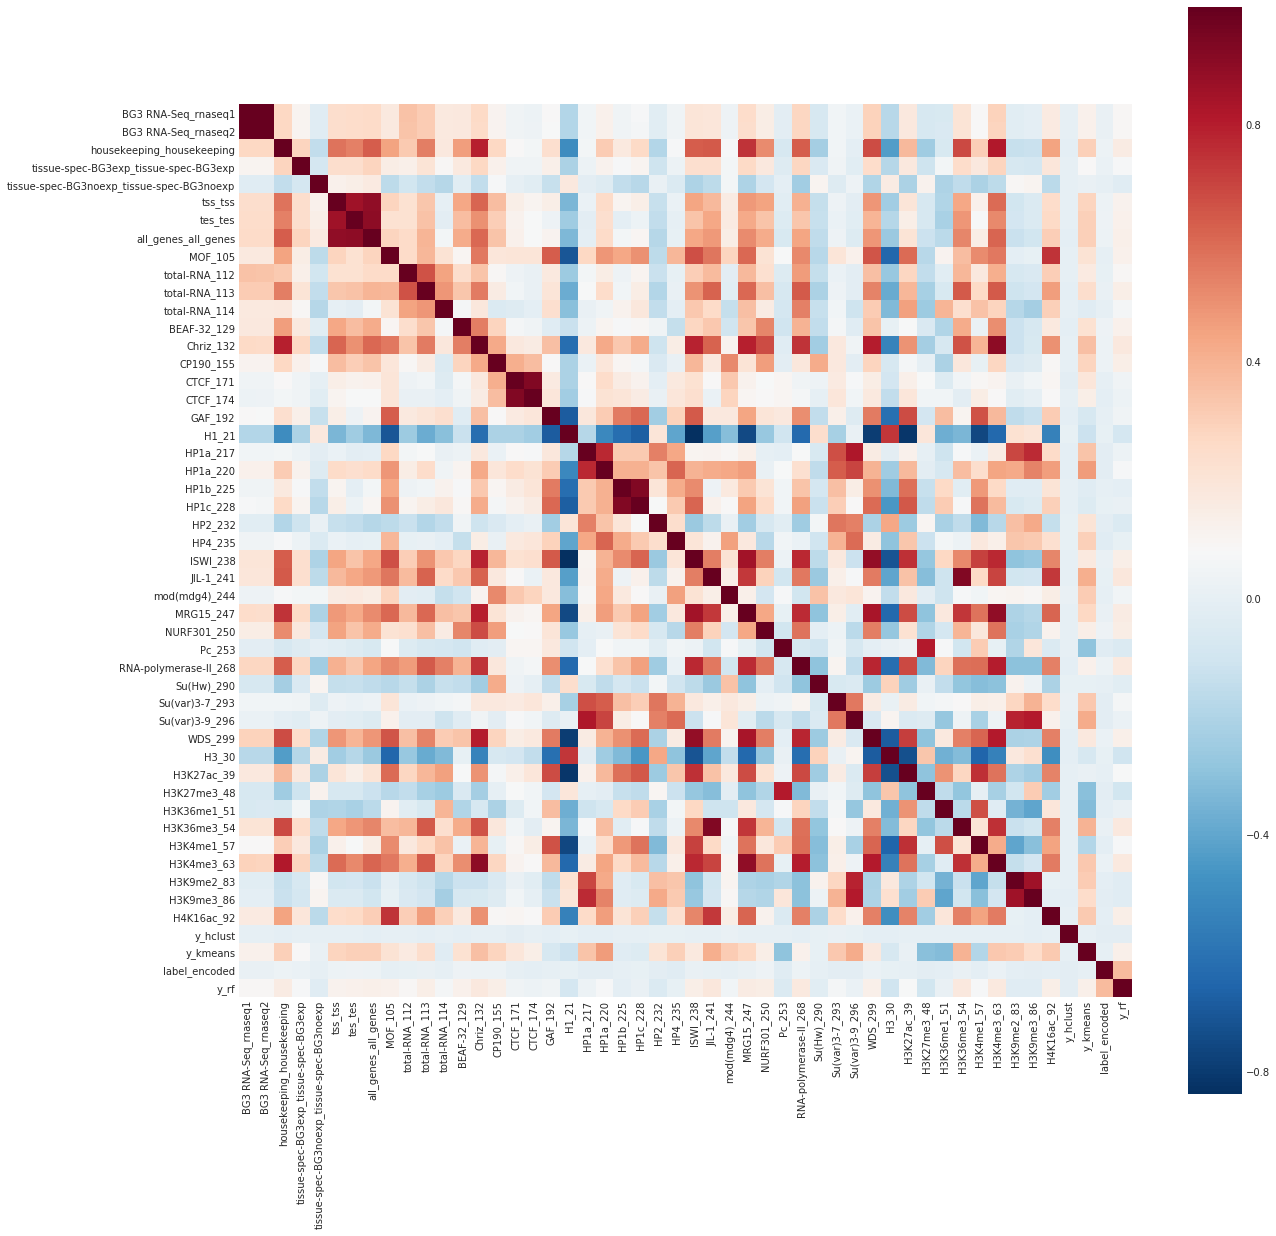

In [283]:
plt.figure(figsize=[20,20])
sns.heatmap(df.loc[:, list(feature_names)+['y_hclust', 'y_kmeans', 'label_encoded', 'y_rf']].corr(), 
            cmap="RdBu_r", square=True)

## Plotting heatmaps

In [21]:
from basic_utils import call_and_check_errors

In [162]:
### Bigwig preparation
# kentUtils = '~/soft/kentUtils/bin/linux.x86_64/bedGraphToBigWig'
# for k, v in f_dict.items():
#     if not k in ['mappability_pop', 'mappability_merged', 'subsampling_support']:
#         continue
#     print(v)
#     if 'binned' in v:
#         command1 = "awk '{{print $1, $2, $2+10000, $3}}' {} > ../DATA/ANNOT/tmp/{}.bedgraph".format(v, k)
#     elif 'bed' in v:
#         command1 = "cp {} ../DATA/ANNOT/tmp/{}.bedgraph".format(v, k)
        
#     command2 = "{} ../DATA/ANNOT/tmp/{}.bedgraph ~/GENOMES/DM3_FASTA/chrom.sizes ../DATA/ANNOT/tmp/{}.bw".format(kentUtils, k, k)
#     call_and_check_errors(command1)
#     call_and_check_errors(command2)

INFO:root:Check stdout: b''
INFO:root:Check stdout: b''


../DATA/TMP/Dros_mappability_10kb_raw.bed
../DATA/TMP/merged_mappability_10kb_raw.bed


INFO:root:Check stdout: b''
INFO:root:Check stdout: b''
INFO:root:Check stdout: b''
INFO:root:Check stdout: b''


../DATA_SUBSAMPLE/borders_subsample_stability.bedgraph


In [256]:
[(x,annot1[x]) for x in selected_tracks]

[('rnaseq1', 'BG3 RNA-Seq'),
 ('rnaseq2', 'BG3 RNA-Seq'),
 ('housekeeping', 'housekeeping'),
 ('tissue-spec-BG3exp', 'tissue-spec-BG3exp'),
 ('tissue-spec-BG3noexp', 'tissue-spec-BG3noexp'),
 ('tss', 'tss'),
 ('tes', 'tes'),
 ('all_genes', 'all_genes'),
 ('mappability_pop', 'mappability_pop'),
 ('mappability_merged', 'mappability_merged'),
 ('is80', 'is80'),
 ('is120', 'is120'),
 ('is100', 'is100'),
 ('105', 'MOF'),
 ('112', 'total-RNA'),
 ('113', 'total-RNA'),
 ('114', 'total-RNA'),
 ('129', 'BEAF-32'),
 ('132', 'Chriz'),
 ('155', 'CP190'),
 ('171', 'CTCF'),
 ('174', 'CTCF'),
 ('192', 'GAF'),
 ('21', 'H1'),
 ('217', 'HP1a'),
 ('220', 'HP1a'),
 ('225', 'HP1b'),
 ('228', 'HP1c'),
 ('232', 'HP2'),
 ('235', 'HP4'),
 ('238', 'ISWI'),
 ('241', 'JIL-1'),
 ('244', 'mod(mdg4)'),
 ('247', 'MRG15'),
 ('250', 'NURF301'),
 ('253', 'Pc'),
 ('268', 'RNA-polymerase-II'),
 ('290', 'Su(Hw)'),
 ('293', 'Su(var)3-7'),
 ('296', 'Su(var)3-9'),
 ('299', 'WDS'),
 ('30', 'H3'),
 ('39', 'H3K27ac'),
 ('48', 'H3

In [266]:
df.columns

Index(['ch', 'pos', 'rnaseq1_BG3 RNA-Seq', 'rnaseq2_BG3 RNA-Seq',
       'housekeeping', 'tissue-spec-BG3exp', 'tissue-spec-BG3noexp', 'tss',
       'tes', 'all_genes', 'mappability_pop', 'mappability_merged', 'is80',
       'is120', 'is100', '105_MOF', '112_total-RNA', '113_total-RNA',
       '114_total-RNA', '129_BEAF-32', '132_Chriz', '155_CP190', '171_CTCF',
       '174_CTCF', '192_GAF', '21_H1', '217_HP1a', '220_HP1a', '225_HP1b',
       '228_HP1c', '232_HP2', '235_HP4', '238_ISWI', '241_JIL-1',
       '244_mod(mdg4)', '247_MRG15', '250_NURF301', '253_Pc',
       '268_RNA-polymerase-II', '290_Su(Hw)', '293_Su(var)3-7',
       '296_Su(var)3-9', '299_WDS', '30_H3', '39_H3K27ac', '48_H3K27me3',
       '51_H3K36me1', '54_H3K36me3', '57_H3K4me1', '63_H3K4me3', '83_H3K9me2',
       '86_H3K9me3', '92_H4K16ac', 'boundary_stable', 'boundary_nearly_stable',
       'boundary_nearly_nonstable', 'boundary_nonstable',
       'boundary_population', 'boundary_merged', 'boundary_randomized',
     

# Reading readymade borders annotation

In [3]:
df1 = pd.read_csv('../DATA_SUBSAMPLE/TMP/subsample_borders_merged_offset0.csv', 
                  low_memory=False, 
                  header=[0,1,2,3], index_col=[0,1])

In [4]:
# Allowing offset = 1
df = (df1==1).copy()
mtx = df.values # Extracting dataframe as matrix for fast numpy computation
for i_col in range(len(df.columns)):
    v = np.where(df.iloc[:, i_col] == 1)[0][1:-1]
    mtx[np.concatenate([v-1, v+1]), i_col] = 1
df.loc[:,:] = mtx

### Subsample stability for subsamples and for types of borders

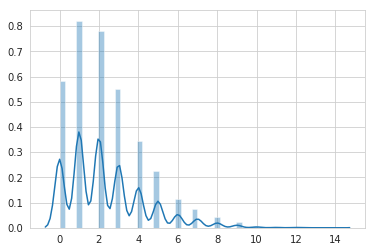

In [8]:
sns.distplot( (df1==1).loc[:, labels_ordered[2:]].sum(axis=1) )

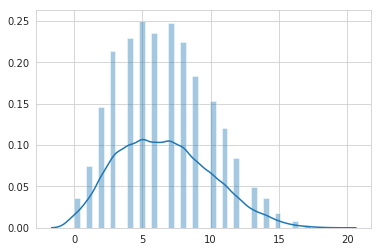

In [7]:
sns.distplot( df.loc[:, labels_ordered[2:]].sum(axis=1) )

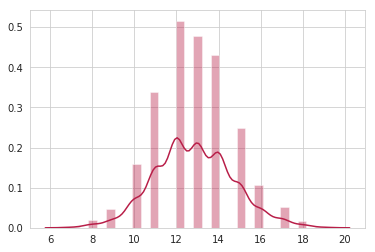

In [245]:
sns.distplot( df_final.loc[:, labels_ordered[2:]].sum(axis=1) )

In [246]:
len(df_final)/len(df), len(df_final), len(df)

(0.07127248277021347, 848, 11898)

In [247]:
(df_final.loc[:, labels_ordered[2:]].sum(axis=1)<5).sum()

0

df_final

In [5]:
oi = [str(x) for x in np.arange(10)]
df_tmp = df.loc(axis=1)[:,:,oi,:]
support = df_tmp.sum(axis=1)/df_tmp.count(axis=1)

oi = [str(x) for x in np.arange(10)]
df_tmp = df.loc(axis=1)[:,:,oi,:].T.reset_index().groupby('cell')
support_bycell = (df_tmp.sum()/df_tmp.count()).T

oi = [str(x) for x in np.arange(10)]
df_tmp = df.loc(axis=1)[:,:,oi,:].T.reset_index().groupby(['cell', 'perc'])
support_bycell_byprc = (df_tmp.sum()/df_tmp.count()).T

presence_bycell = df.loc[:, labels_ordered[2:]].T.reset_index().drop(['colname', 'niter', 'perc'], axis=1).set_index('cell').T

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Compute nice plots
Out of groups of bins: 

In [64]:
tmp = df_perc_under.groupby('perc').mean()
tmp = tmp.set_index(tmp.index.astype(int)).sort_index(ascending=False)<=0.75



In [88]:
thresholds = pd.DataFrame(tmp.index[tmp.apply(lambda x: np.where(x==True)[0][-1], axis=0)], index=tmp.columns)
selected_prc = np.arange(thresholds.loc[exp].values[0], 105, 5)

In [194]:
labels_ordered

['population',
 'merged',
 'A6',
 'B31',
 'A8',
 'A5',
 'sc23',
 'B26',
 'B19',
 'B16',
 'sc16',
 'B3',
 'A2',
 'A3',
 'sc1',
 'B6',
 'A9',
 'sc24',
 'sc29',
 'sc19',
 'sc21',
 'B15']

In [240]:
exp = 'B15'
df_exp = df.loc(axis=1)[:, exp, :, ['100', '90', '95', '80', '85']].T
golden_standard = df_exp.loc[exp,:].values[0]

tmp = df_exp.loc[:,golden_standard]
v = tmp.sum(axis=0)/len(tmp)

tmp = df_exp.loc[:,np.logical_not(golden_standard)]
v1 = tmp.sum(axis=0)/len(tmp)


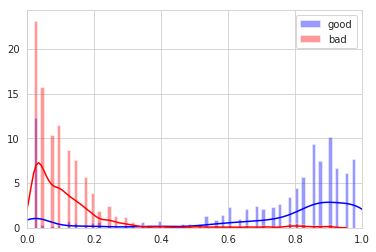

In [241]:
sns.distplot(v[v>0], bins=np.arange(0,1,0.01), label='good', color='blue')
sns.distplot(v1[v1>0], bins=np.arange(0,1,0.01), label='bad', color='red')
plt.xlim(0,1)
plt.legend()

In [242]:
th = 0.4
tmp = df.loc(axis=1)[:, :, :, ['90', '95', '80', '85']].T
good_bins = (tmp.sum(axis=0)/len(tmp)>th)
good_bins = good_bins[good_bins.values].index

In [243]:
df_final = df.loc[good_bins,experiment_ids]

In [166]:
exp = 'A6'
th = 80 #thresholds.loc[exp].values[0]
tmp = df.loc(axis=1)[:, exp, :, :].T
golden_standard = tmp.loc[exp,:].values
tmp = tmp.reset_index()
tmp.loc[:, 'perc'] = tmp.perc.astype(int)
tmp = tmp.set_index('colname')
v = tmp.loc[tmp.perc>th, golden_standard[0]].mean(axis=0)
v1 = tmp.loc[tmp.perc>th, np.logical_not(golden_standard[0])].mean(axis=0)

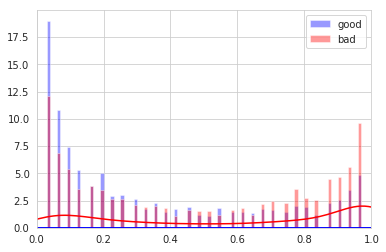

In [6]:
df_perc = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    selected_prc = np.arange(thresholds.loc[exp].values[0], 105, 5)
    
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * golden_standard ).sum(axis=0)/golden_standard.sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc)==0:
        df_perc = df_tmp.copy()
    else:
        df_perc = pd.merge(df_perc, df_tmp, left_index=True, right_index=True)

NameError: name 'thresholds' is not defined

In [ ]:
thresholds

In [7]:
df_perc = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * golden_standard ).sum(axis=0)/golden_standard.sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc)==0:
        df_perc = df_tmp.copy()
    else:
        df_perc = pd.merge(df_perc, df_tmp, left_index=True, right_index=True)

In [21]:
df_perc_over = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * np.logical_not(golden_standard) ).sum(axis=0)/np.logical_not(golden_standard).sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_over)==0:
        df_perc_over = df_tmp.copy()
    else:
        df_perc_over = pd.merge(df_perc_over, df_tmp, left_index=True, right_index=True)

In [47]:
df_perc_under = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( np.logical_not(mtx) * golden_standard ).sum(axis=0)/golden_standard.sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_under)==0:
        df_perc_under = df_tmp.copy()
    else:
        df_perc_under = pd.merge(df_perc_under, df_tmp, left_index=True, right_index=True)

In [ ]:
# abs count

In [74]:
pd.DataFrame([(exp,df.loc[:,exp].values.sum(), len(df.loc[:,exp].values)) for exp in labels_ordered[2:]], columns=['cell', 'nbins', 'total_bins'])

cell  nbins  total_bins
0     A6   4427       11898
1    B31   4061       11898
2     A8   4524       11898
3     A5   4553       11898
4   sc23   4236       11898
5    B26   4015       11898
6    B19   4062       11898
7    B16   4164       11898
8   sc16   4250       11898
9     B3   4316       11898
10    A2   4191       11898
11    A3   4304       11898
12   sc1   4117       11898
13    B6   3820       11898
14    A9   3623       11898
15  sc24   3378       11898
16  sc29   3464       11898
17  sc19   3135       11898
18  sc21   3108       11898
19   B15   2781       11898

In [ ]:
len(df)

In [60]:
df_perc_over = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * np.logical_not(golden_standard) ).sum(axis=0)#/np.logical_not(golden_standard).sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_over)==0:
        df_perc_over = df_tmp.copy()
    else:
        df_perc_over = pd.merge(df_perc_over, df_tmp, left_index=True, right_index=True)

Text(0.5,1,'Percentage plot')

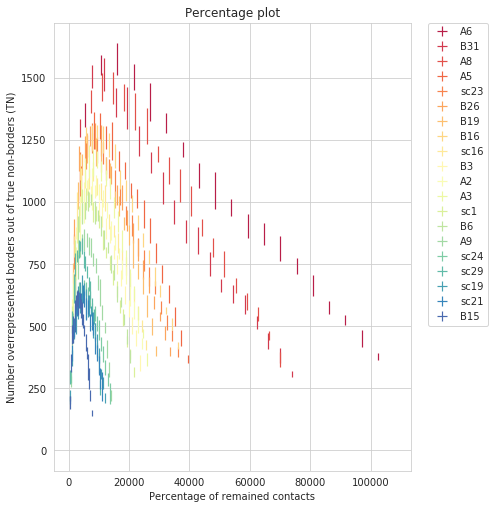

In [61]:
sns.set_palette('Spectral', 20)
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_over.groupby('perc').mean()[exp].reset_index()['perc'].astype(int)\
        *contacts_counts.loc[exp,'ncontacts']/100
    stderr_x = np.ones(len(means_x))
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(means_x, means_y, label=exp,
                 xerr=stderr_x, 
                 yerr=stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Percentage of remained contacts')
plt.ylabel('Number overrepresented borders out of true non-borders (TN)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

#plt.savefig('../IMG/SUBSAMPLE/overrepr.pdf')

In [58]:
df_perc_under = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( np.logical_not(mtx) * golden_standard ).sum(axis=0)#/golden_standard.sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_under)==0:
        df_perc_under = df_tmp.copy()
    else:
        df_perc_under = pd.merge(df_perc_under, df_tmp, left_index=True, right_index=True)

Text(0.5,1,'Percentage plot')

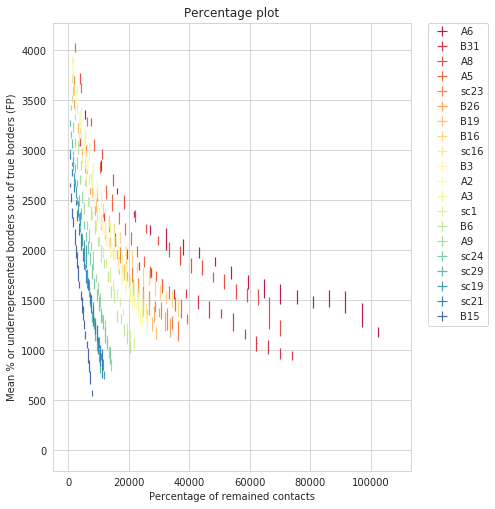

In [59]:
sns.set_palette('Spectral', 20)
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp].reset_index()['perc'].astype(int)\
        *contacts_counts.loc[exp,'ncontacts']/100
    stderr_x = np.ones(len(means_x))
    means_y  = df_perc_under.groupby('perc').mean()[exp]
    stderr_y = df_perc_under.groupby('perc').std()[exp]
    plt.errorbar(means_x, means_y, label=exp,
                 xerr=stderr_x, 
                 yerr=stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Percentage of remained contacts')
plt.ylabel('Number of underrepresented borders out of true borders (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

#plt.savefig('../IMG/SUBSAMPLE/underrepr.pdf')

In [10]:
contacts_counts = pd.DataFrame(index=experiment_ids)
for exp in experiment_ids:
    f = "../DATA/COOL/{}.10.cool".format(exp)
    ncontacts = cooler.Cooler(f).pixels()[:]['count'].sum()
    contacts_counts.loc[exp,'ncontacts'] = ncontacts

Text(0.5,1,'Percentage plot')

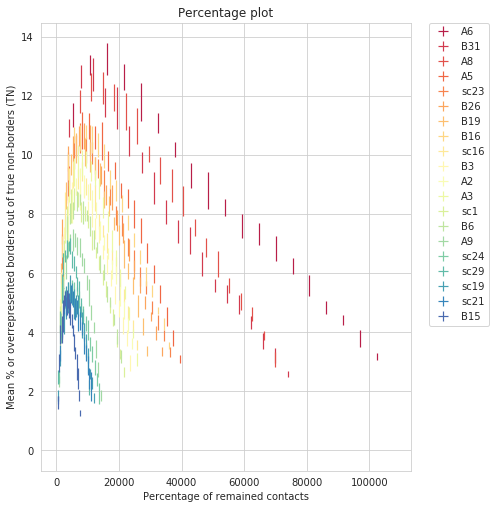

In [25]:
sns.set_palette('Spectral', 20)
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_over.groupby('perc').mean()[exp].reset_index()['perc'].astype(int)\
        *contacts_counts.loc[exp,'ncontacts']/100
    stderr_x = np.ones(len(means_x))
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(means_x, 100*means_y, label=exp,
                 xerr=stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Percentage of remained contacts')
plt.ylabel('Mean % or overrepresented borders out of true non-borders (TN)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

#plt.savefig('../IMG/SUBSAMPLE/overrepr.pdf')

Text(0.5,1,'Percentage plot')

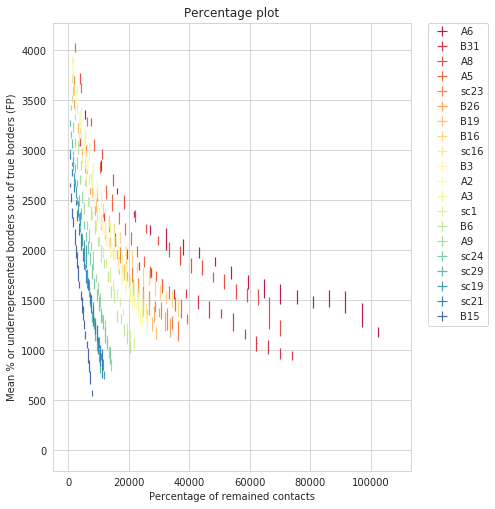

In [53]:
sns.set_palette('Spectral', 20)
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp].reset_index()['perc'].astype(int)\
        *contacts_counts.loc[exp,'ncontacts']/100
    stderr_x = np.ones(len(means_x))
    means_y  = df_perc_under.groupby('perc').mean()[exp]
    stderr_y = df_perc_under.groupby('perc').std()[exp]
    plt.errorbar(means_x, 100*means_y, label=exp,
                 xerr=stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Percentage of remained contacts')
plt.ylabel('Mean % or underrepresented borders out of true borders (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

plt.savefig('../IMG/SUBSAMPLE/underrepr.pdf')

Text(0.5,1,'Percentage plot')

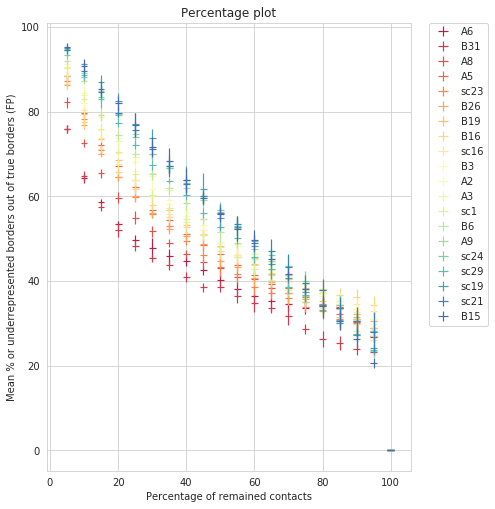

In [51]:
sns.set_palette('Spectral', 20)
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp].reset_index()['perc'].astype(int)
    stderr_x = np.ones(len(means_x))
    means_y  = df_perc_under.groupby('perc').mean()[exp]
    stderr_y = df_perc_under.groupby('perc').std()[exp]
    plt.errorbar(means_x, 100*means_y, label=exp,
                 xerr=stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Percentage of remained contacts')
plt.ylabel('Mean % or underrepresented borders out of true borders (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

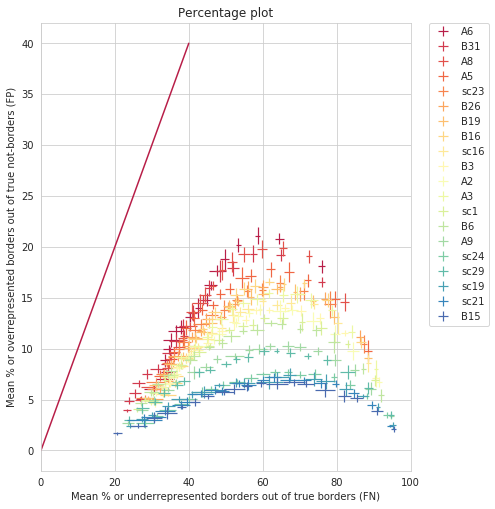

In [827]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp]
    stderr_x = df_perc_under.groupby('perc').std()[exp]
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or underrepresented borders out of true borders (FN)')
plt.ylabel('Mean % or overrepresented borders out of true not-borders (FP)')
plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])
plt.plot([0,40], [0,40])

Text(0.5,1,'Percentage plot')

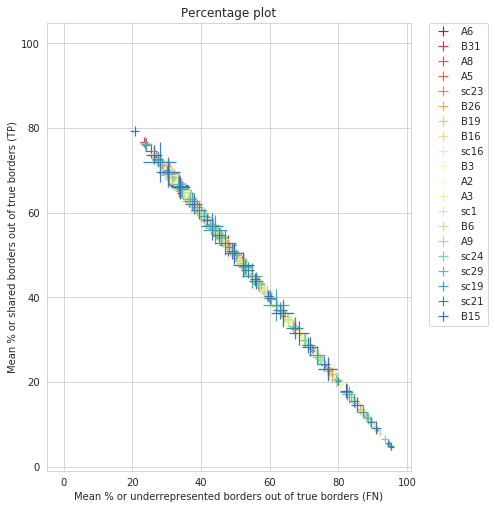

In [786]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp]
    stderr_x = df_perc_under.groupby('perc').std()[exp]
    means_y  = df_perc.groupby('perc').mean()[exp]
    stderr_y = df_perc.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or underrepresented borders out of true borders (FN)')
plt.ylabel('Mean % or shared borders out of true borders (TP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

Text(0.5,1,'Percentage plot')

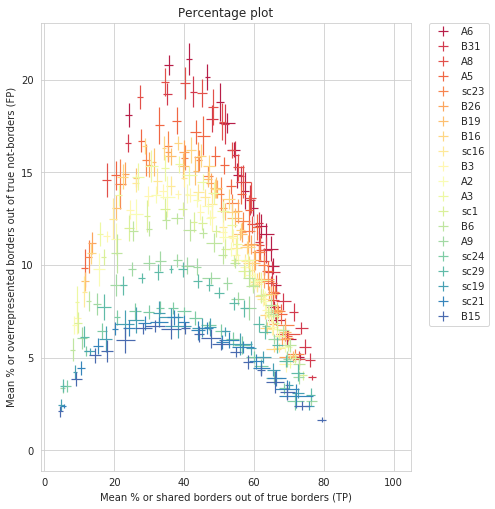

In [787]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc.groupby('perc').mean()[exp]
    stderr_x = df_perc.groupby('perc').std()[exp]
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or shared borders out of true borders (TP)')
plt.ylabel('Mean % or overrepresented borders out of true not-borders (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### Types of boundaries

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [570]:
v = df.loc[:, labels_ordered[2:]].sum(axis=1)
idx_more15 = (v[v>=15]).index.copy()
idx_more10 = (v[v>=10]).index.copy()
idx_less10 = (v[v<10]).index.copy()
idx_1 = (v[v==1]).index.copy()
idx_never = (v[v<1]).index.copy()

In [575]:
toplot = {
    'more15' : idx_more15,
    'more10' : idx_more10,
    'less10' : idx_less10,
    '1'      : idx_1,
    'never'  : idx_never
}

In [597]:
len(df)

11898

In [604]:
df_tmp = pd.DataFrame([(k, len(toplot[k])) for k in toplot.keys()]+[['total_bins', len(df)]],
            columns=['type', '#'])

df_tmp.loc[:,'prc'] = 100*df_tmp.loc[:,'#']/df_tmp.loc[5,"#"]

In [605]:
df_tmp

type      #         prc
0      more15    158    1.327954
1      more10   2447   20.566482
2      less10   9451   79.433518
3           1    381    3.202219
4       never    183    1.538074
5  total_bins  11898  100.000000

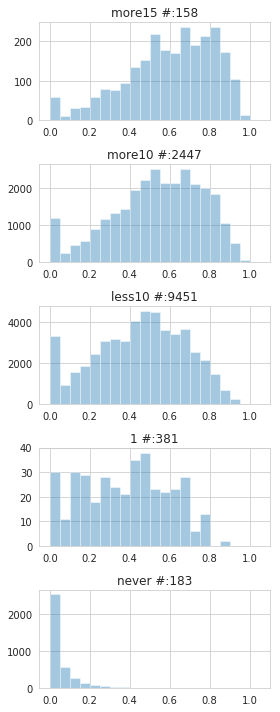

In [407]:
f, axes = plt.subplots(len(toplot.items()), 1, sharey=False, figsize=(4,10))

bins = np.arange(0, 1.1, 0.05)

for i, (k, idx) in enumerate(toplot.items()):
    if k=='never':
        v = support_bycell.loc[idx].values.flatten()
    else:
        v = support_bycell[presence_bycell].loc[idx].values.flatten()
    v = v[np.isfinite(v)]
    sns.distplot( v, kde=False, bins=bins, ax=axes[i] ) # label=k, 
    axes[i].set_title("{} #:{}".format(k, len(idx)))

#f.legend()
f.tight_layout()

In [622]:
idx = pd.IndexSlice 

In [670]:
# prcs = [str(x) for x in np.arange(5, 100, 5)]

# f, axes = plt.subplots(len(prcs), 1, sharey=False, figsize=(2,25))

# bins = np.arange(0, 1.1, 0.05)

# for i, prc in enumerate(prcs):
#     v1 = support_bycell_byprc.loc[toplot['never'], idx[:, prc]].values.flatten()
#     v1 = v1[np.isfinite(v1)]
#     sns.distplot( v1, kde=False, bins=bins, ax=axes[i], label='never')  

#     v2 = support_bycell_byprc.loc[toplot['1'], idx[:, prc]].values.flatten()
#     v2 = v2[np.isfinite(v2)]
#     sns.distplot( v2, kde=False, bins=bins, ax=axes[i], label='more15')
    
#     axes[i].set_ylabel("{}".format(prc))

# axes[0].legend()
    
# f.tight_layout()

In [684]:
from sklearn import svm

v1 = support_bycell.loc[toplot['never']].values.flatten()
v1 = v1[np.isfinite(v1)]
v2 = support_bycell[presence_bycell].loc[toplot['1']].values.flatten()
v2 = v2[np.isfinite(v2)]

X = np.r_[v1, v2].reshape(-1, 1)
y = np.r_[np.zeros(len(v1)), np.ones(len(v2))].reshape(-1, 1)

In [685]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y) 
th = -clf.intercept_[0]/clf.coef_[0][0]
print(th)

0.3289473644825576


/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


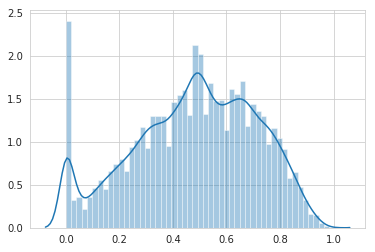

In [409]:
v = support_bycell[presence_bycell].values.flatten()
v = v[np.isfinite(v)]
sns.distplot( v ) 

In [410]:
oi = [str(x) for x in np.arange(10)]
df_tmp = df.loc(axis=1)[:,:,oi,:].T.reset_index().groupby('perc')
support_byprc = (df_tmp.sum()/df_tmp.count()).T

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


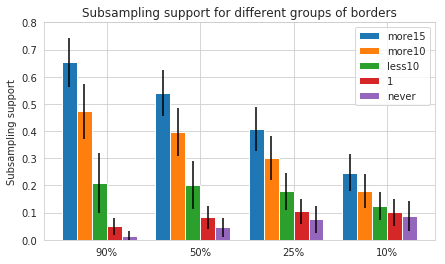

In [412]:
plt.figure(figsize=[7,4])

groups = ['90', '50', '25', '10']
ind = np.arange(len(groups))

categories = toplot.keys()
catMeans = {k:support_byprc.loc[idx, groups].mean(axis=0) for k, idx in toplot.items()}
catStds = {k:support_byprc.loc[idx, groups].std(axis=0) for k, idx in toplot.items()}

width = 0.8/len(categories)

p = []
for i, c in enumerate(categories):
    p.append( plt.bar(ind+width*i, catMeans[c], width, yerr=catStds[c]) )
    
plt.ylabel('Subsampling support')
plt.title('Subsampling support for different groups of borders')
plt.xticks(ind+(width*len(categories)/2), [x+'%' for x in groups])
plt.ylim(0,0.8)
plt.legend(p, categories)

plt.savefig("../IMG/BIBM/1_subsampling_support.pdf")

### Filtering by threshold

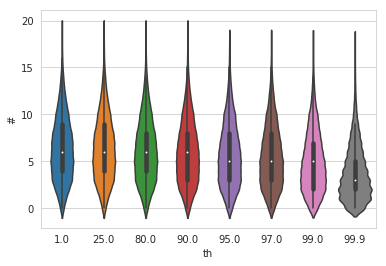

In [686]:
vs = {}
ths = [1, 25, 80, 90, 95, 97, 99, 99.9]
for p in ths:
    th = np.nanpercentile(support_bycell.loc[idx_never].values.flatten(), p)
    presence_filtered_bycell = presence_bycell*(support_bycell>th)
    v = (presence_filtered_bycell).sum(axis=1)
    vs[p] = v.copy()
    
df_tmp = pd.DataFrame(vs).stack().reset_index()
df_tmp.columns = ['ch', 'pos', 'th', '#']
sns.violinplot(x='th', y='#', data=df_tmp)
#plt.xticks(np.arange(len(ths))+1, ths)

In [704]:
th = 0.6 #np.nanpercentile(support_bycell.loc[idx_never].values.flatten(), 99.99)
presence_filtered_bycell = presence_bycell*(support_bycell>th)

print(th)

v = (presence_filtered_bycell).sum(axis=1)
idx_filtered_more15 = (v[v>=15]).index
idx_filtered_more10 = (v[v>=10]).index
idx_filtered_less10 = (v[v<10]).index
idx_filtered_1 = (v[v==1]).index
idx_filtered_never = (v[v<1]).index

0.6


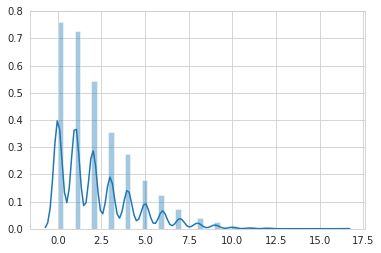

In [705]:
sns.distplot( v )

In [706]:
toplot_filtered = {
    'more15' : idx_filtered_more15,
    'more10' : idx_filtered_more10,
    'less10' : idx_filtered_less10,
    '1'      : idx_filtered_1,
    'never'  : idx_filtered_never
}

In [707]:
for k, idx in toplot_filtered.items():
    print(k, len(idx))

more15 4
more10 86
less10 11815
1 2768
never 2899


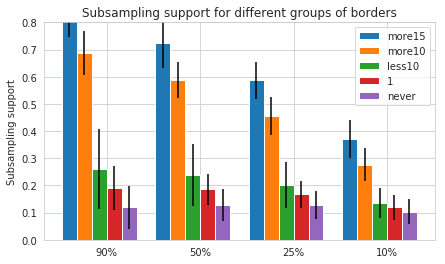

In [708]:
plt.figure(figsize=[7,4])

groups = ['90', '50', '25', '10']
ind = np.arange(len(groups))

categories = toplot_filtered.keys()
catMeans = {k:support_byprc.loc[idx, groups].mean(axis=0) for k, idx in toplot_filtered.items()}
catStds = {k:support_byprc.loc[idx, groups].std(axis=0) for k, idx in toplot_filtered.items()}

width = 0.8/len(categories)

p = []
for i, c in enumerate(categories):
    p.append( plt.bar(ind+width*i, catMeans[c], width, yerr=catStds[c]) )
    
plt.ylabel('Subsampling support')
plt.title('Subsampling support for different groups of borders')
plt.xticks(ind+(width*len(categories)/2), [x+'%' for x in groups])
plt.ylim(0,0.8)
plt.legend(p, categories)

#plt.savefig("../IMG/BIBM/1_subsampling_support1.pdf")

### Percentage of shared borders from subsample number

In [395]:
df_perc = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * golden_standard ).sum(axis=0)/golden_standard.sum()
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc)==0:
        df_perc = df_tmp.copy()
    else:
        df_perc = pd.merge(df_perc, df_tmp, left_index=True, right_index=True)

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


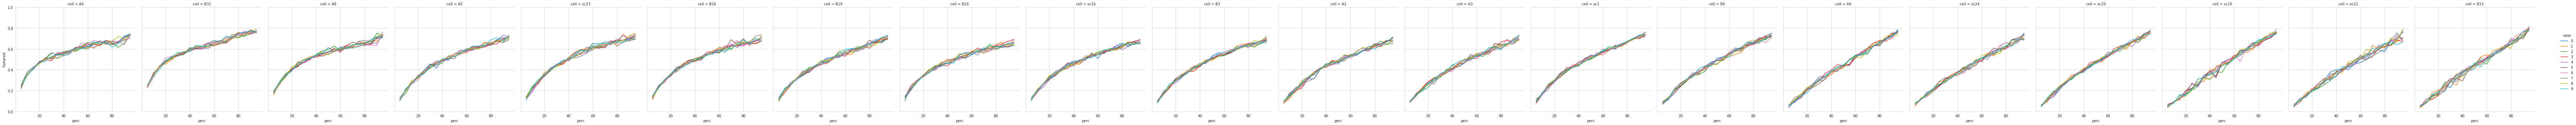

In [396]:
df_perc_stack = df_perc.stack().reset_index()
df_perc_stack.perc = df_perc_stack.perc.astype(int)
#.sort_values('perc')
df_perc_stack.columns = ['niter', 'perc', 'cell', '%shared']

#g = sns.FacetGrid(data=df_perc_stack, col='cell', hue='niter', sharex=True, sharey=True)
#g.map(plt.plot, 'perc', '%shared')


df_perc_stack.perc = df_perc_stack.perc.astype(int)
df_perc_stack.loc[:, 'ordered'] = df_perc_stack.apply(lambda x: order_dict[x.cell], axis=1)
df_perc_stack = df_perc_stack.query('perc<100').sort_values(['perc', 'ordered'])

g = sns.FacetGrid(data=df_perc_stack, col='cell', hue='niter', size=5, ylim=[0,1])
g.map(plt.plot, 'perc', '%shared')
g.add_legend()

g.savefig("../IMG/BIBM/2_downsampling_robustness_byrow.pdf")

In [397]:
order_dict = {x:i for i, x in enumerate(labels_ordered[2:])}

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


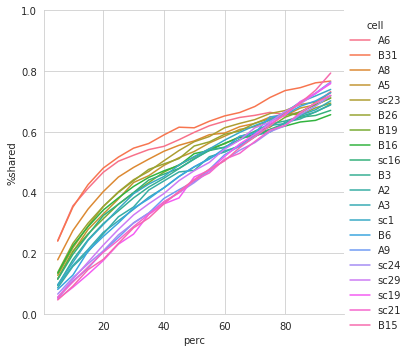

In [398]:
df_perc_stack = df_perc.groupby('perc', axis=0).mean().stack().reset_index()
df_perc_stack.columns = ['perc', 'cell', '%shared']
df_perc_stack.perc = df_perc_stack.perc.astype(int)
df_perc_stack.loc[:, 'ordered'] = df_perc_stack.apply(lambda x: order_dict[x.cell], axis=1)
df_perc_stack = df_perc_stack.query('perc<100').sort_values(['perc', 'ordered'])

g = sns.FacetGrid(data=df_perc_stack, hue='cell', size=5, ylim=[0,1])
g.map(plt.plot, 'perc', '%shared')
g.add_legend()

g.savefig("../IMG/BIBM/2_downsampling_robustness_overlay.pdf")

#### By group of boundary:

In [697]:
df_perc = pd.DataFrame()

for group, idx in toplot_filtered.items():
    df_tmp = df.loc[idx, :]
    print(group, len(df_tmp))
    
    for exp in labels_ordered[2:]:

        golden_standard = df_tmp.loc[:,exp].values 
        if 'never'  in group:
            golden_standard = golden_standard+1
        mtx = df_tmp.loc(axis=1)[:, exp, :, :].values
        colnames = df_tmp.loc(axis=1)[:, exp, :, :].columns

        v = np.nansum( mtx * golden_standard, axis=0)/np.nansum( golden_standard )

        df_perc_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
            .reset_index().drop(['colname', 'cell'], axis=1)\
            .set_index(['niter', 'perc']).T.reset_index()
            
        df_perc_tmp.loc[:, 'group'] = group
        df_perc_tmp = df_perc_tmp.set_index(['index', 'group']).T
        
        if len(df_perc)==0:
            df_perc = df_perc_tmp.copy()
        else:
            df_perc = pd.merge(df_perc, df_perc_tmp, left_index=True, right_index=True)

more15 7
more10 235
less10 11666
1 2362
never 1821


In [698]:
perc_byprc = df_perc.T.stack(level=0).reset_index().set_index('group')

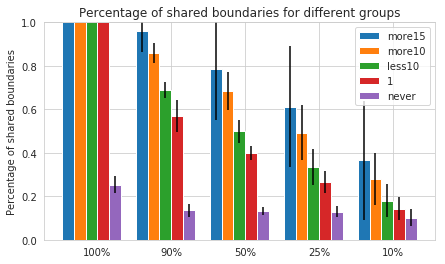

In [699]:
plt.figure(figsize=[7,4])

groups = ['100', '90', '50', '25', '10']
ind = np.arange(len(groups))

categories = toplot.keys()
catMeans = {k:perc_byprc.loc[k, groups].mean(axis=0) for k, idx in toplot.items()}
catStds = {k:perc_byprc.loc[k, groups].std(axis=0) for k, idx in toplot.items()}

width = 0.8/len(categories)

p = []
for i, c in enumerate(categories):
    p.append( plt.bar(ind+width*i, catMeans[c], width, yerr=catStds[c]) )
    
plt.ylabel('Percentage of shared boundaries')
plt.title('Percentage of shared boundaries for different groups')
plt.xticks(ind+(width*len(categories)/2), [x+'%' for x in groups])
plt.ylim(0,1.0)
plt.legend(p, categories)

#plt.savefig("../IMG/BIBM/1_shared_boundaries_per_group.pdf")

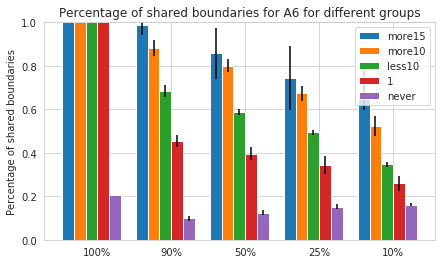

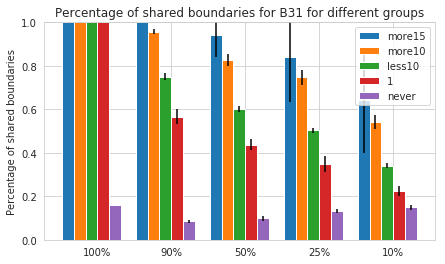

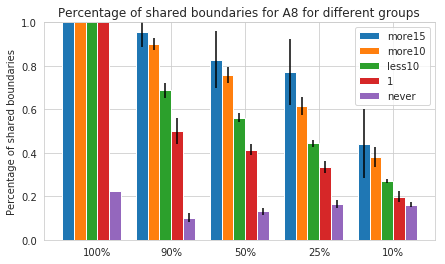

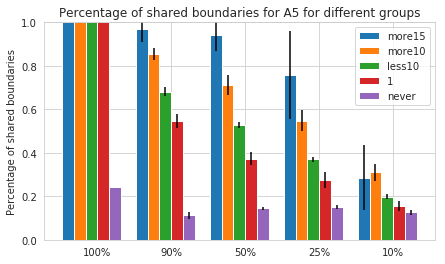

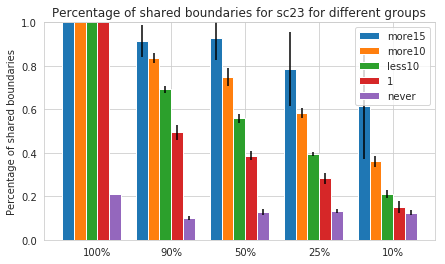

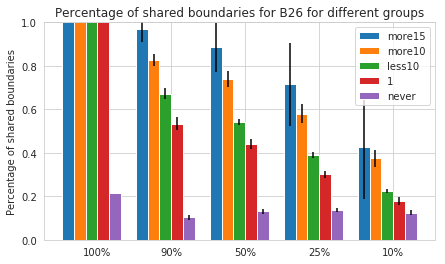

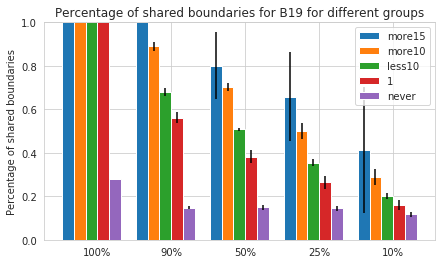

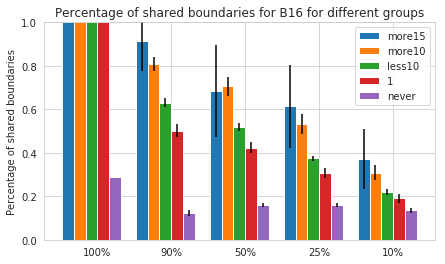

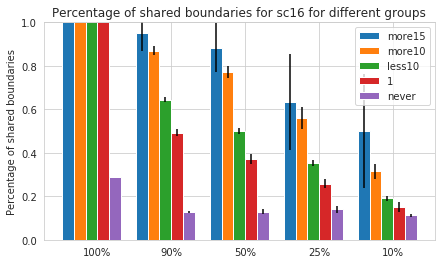

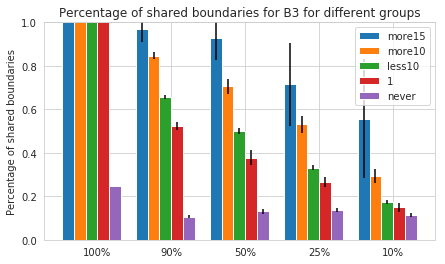

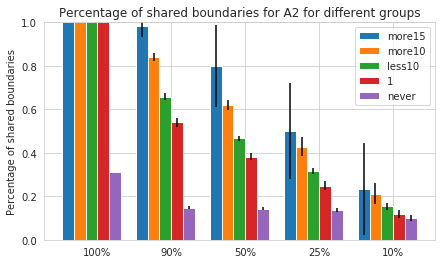

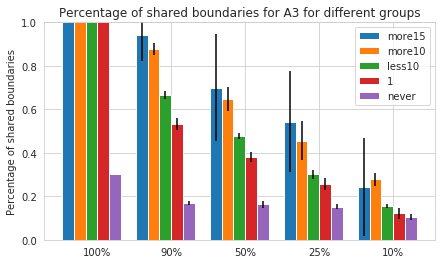

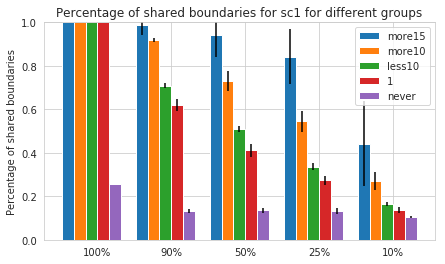

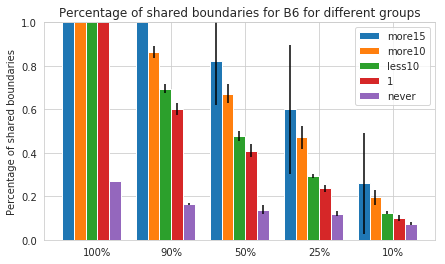

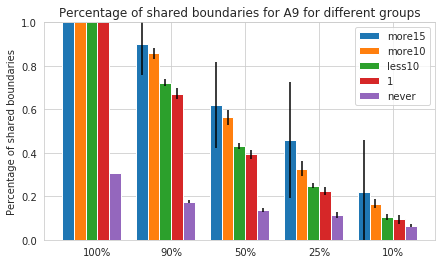

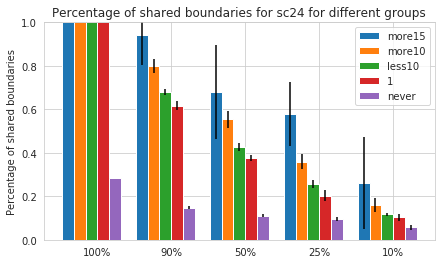

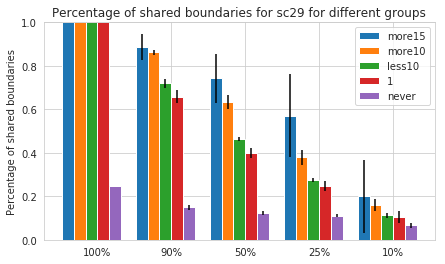

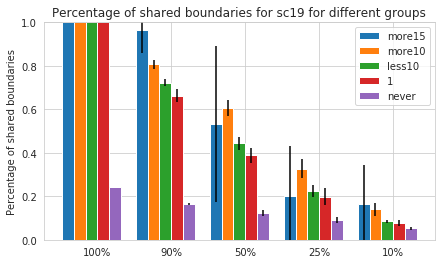

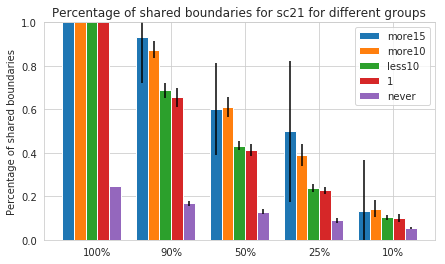

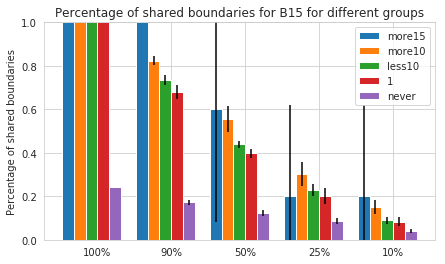

In [700]:
for exp in labels_ordered[2:]:
    plt.figure(figsize=[7,4])

    groups = ['100', '90', '50', '25', '10']
    ind = np.arange(len(groups))

    categories = toplot.keys()
    catMeans = {k:perc_byprc.query('index=="{}"'.format(exp)).loc[k, groups].mean(axis=0) for k, idx in toplot.items()}
    catStds = {k:perc_byprc.query('index=="{}"'.format(exp)).loc[k, groups].std(axis=0) for k, idx in toplot.items()}

    width = 0.8/len(categories)

    p = []
    for i, c in enumerate(categories):
        p.append( plt.bar(ind+width*i, catMeans[c], width, yerr=catStds[c]) )

    plt.ylabel('Percentage of shared boundaries')
    plt.title('Percentage of shared boundaries for {} for different groups'.format(exp))
    plt.xticks(ind+(width*len(categories)/2), [x+'%' for x in groups])
    plt.ylim(0,1.0)
    plt.legend(p, categories)

    #plt.savefig("../IMG/BIBM/1_shared_boundaries_per_group_{}.pdf".format(exp))

### Epigenetics analysis

In [213]:
import bbi
import matplotlib.gridspec as gridspec

In [214]:
df_epi = pd.read_csv("../DATA_SUBSAMPLE/full_boundary_annotation_table.csv")

FileNotFoundError: File b'../DATA_SUBSAMPLE/full_boundary_annotation_table.csv' does not exist

In [380]:
[(annot1[x], x) for x in selected_tracks]

[('BG3 RNA-Seq', 'rnaseq1'),
 ('BG3 RNA-Seq', 'rnaseq2'),
 ('housekeeping', 'housekeeping'),
 ('tissue-spec-BG3exp', 'tissue-spec-BG3exp'),
 ('tissue-spec-BG3noexp', 'tissue-spec-BG3noexp'),
 ('tss', 'tss'),
 ('tes', 'tes'),
 ('all_genes', 'all_genes'),
 ('mappability_pop', 'mappability_pop'),
 ('mappability_merged', 'mappability_merged'),
 ('is80', 'is80'),
 ('is120', 'is120'),
 ('is100', 'is100'),
 ('MOF', '105'),
 ('total-RNA', '112'),
 ('total-RNA', '113'),
 ('total-RNA', '114'),
 ('BEAF-32', '129'),
 ('Chriz', '132'),
 ('CP190', '155'),
 ('CTCF', '171'),
 ('CTCF', '174'),
 ('GAF', '192'),
 ('H1', '21'),
 ('HP1a', '217'),
 ('HP1a', '220'),
 ('HP1b', '225'),
 ('HP1c', '228'),
 ('HP2', '232'),
 ('HP4', '235'),
 ('ISWI', '238'),
 ('JIL-1', '241'),
 ('mod(mdg4)', '244'),
 ('MRG15', '247'),
 ('NURF301', '250'),
 ('Pc', '253'),
 ('RNA-polymerase-II', '268'),
 ('Su(Hw)', '290'),
 ('Su(var)3-7', '293'),
 ('Su(var)3-9', '296'),
 ('WDS', '299'),
 ('H3', '30'),
 ('H3K27ac', '39'),
 ('H3K27me3

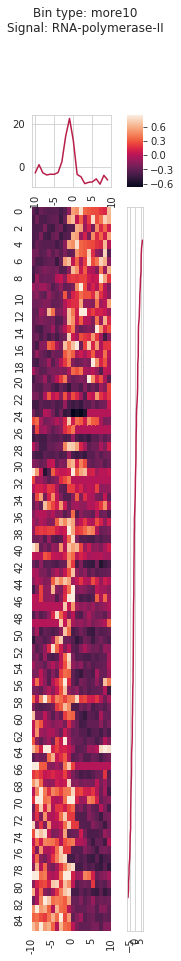

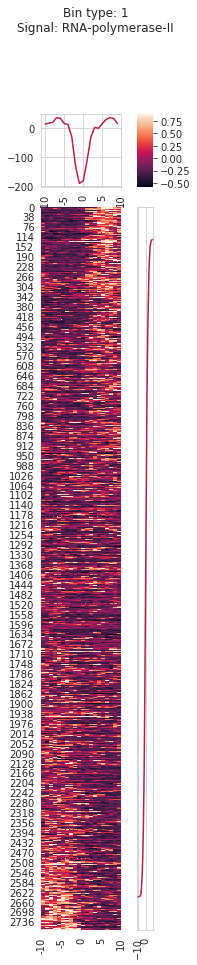

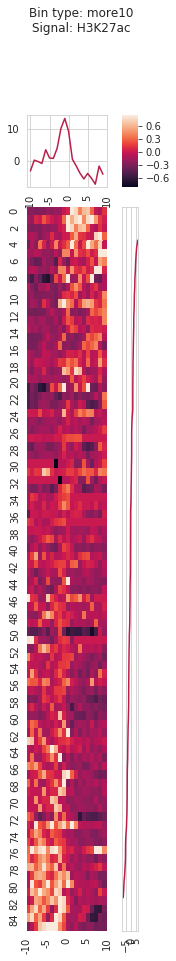

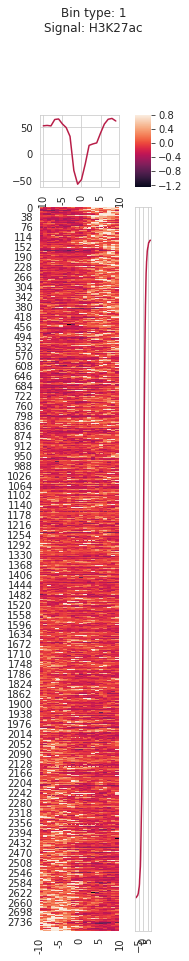

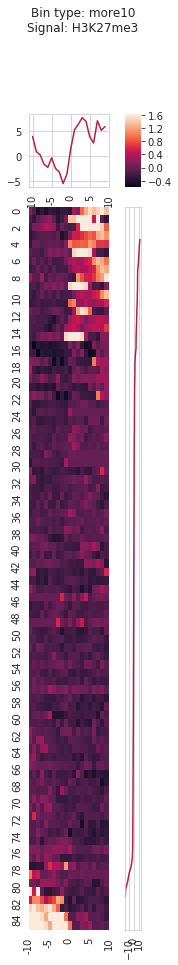

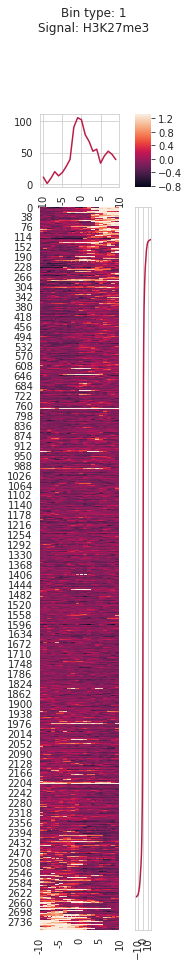

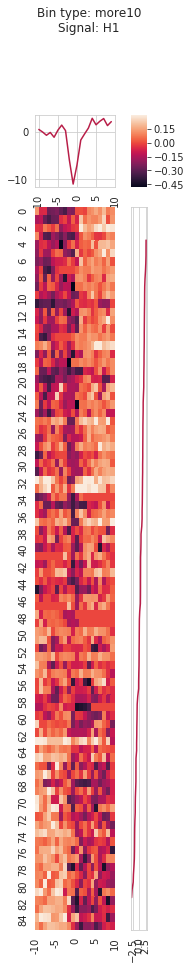

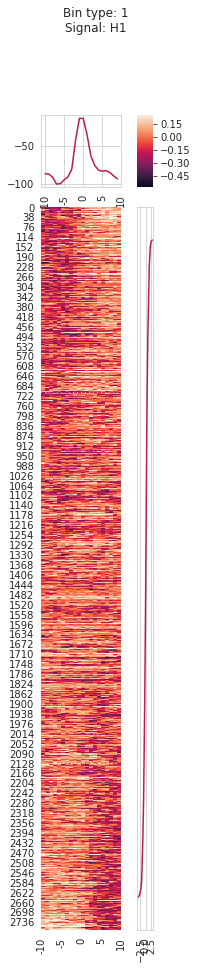

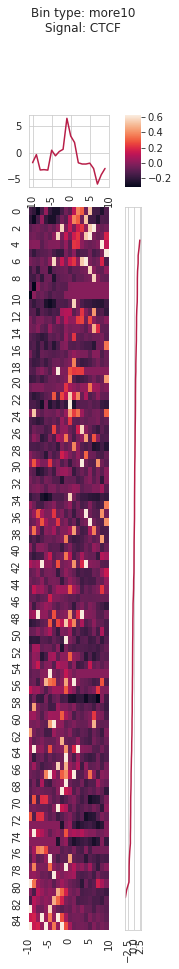

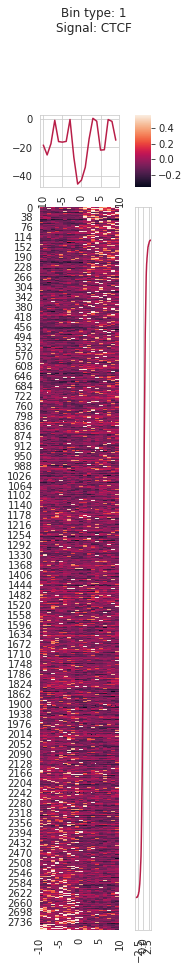

In [801]:
for k in ['268', '39', '48', '21', '171']:
    
    path = '../DATA/ANNOT/tmp/{}.bw'.format(k)
    name = annot1[k]

    window = 100000 # window size (one-sided)
    nbins = 20 # number of bins in the window

    for cat, idx in toplot_filtered.items():
        if cat!='more10' and cat!='1':
            continue

        # df_tmp is the dataframe of anchors with columns ch=chromosomes, pos=positions of anchors
        df_tmp = df.loc[idx,[]].reset_index()
        df_tmp.columns = ['ch', 'pos']

        chroms = df_tmp.ch
        starts = df_tmp.pos-window
        ends   = df_tmp.pos+window

        # Creation of numpy 2D array with annotation snippets
        s = bbi.stackup(path, chroms, starts, ends, bins=nbins) 
        s[np.isnan(s)] = 0

        # Ordering
        for_order = (s[:,10:].sum(axis=1)-s[:,:11].sum(axis=1)) #s[:,8:13].sum(axis=1) # ordering by central values of stack
        order = np.argsort(for_order)[::-1]

        # Plotting and tuning the plot
        fig = plt.figure(figsize=[2,15])
        gs = gridspec.GridSpec(2, 3,
                               width_ratios=[5, 1, 1],
                               height_ratios=[1, 10], 
                               wspace=0.0, hspace=0.05)

        ax_col_marg = plt.subplot(gs[0]) # upper profile
        ax_row_marg = plt.subplot(gs[5]) # right marginal distribution of rows or custom numbers
        ax_bar = plt.subplot(gs[2]) # colorbar
        ax_heatmap = plt.subplot(gs[3]) # heatmap

        sns.heatmap(s[order,:], ax=ax_heatmap, cbar_ax=ax_bar, vmax=np.percentile(a=s.flatten(), q=98))
        ax_heatmap.set_xticks(np.arange(0, nbins+1, 5))
        ax_heatmap.set_xticklabels(np.arange(-nbins/2, 1+nbins/2, 5).astype(int), rotation=90)
        ax_col_marg.set_xticks(np.arange(0, nbins+1, 5))
        ax_col_marg.set_xticklabels(np.arange(-nbins/2, 1+nbins/2, 5).astype(int), rotation=90)

        ax_row_marg.set_yticks([])
        ax_row_marg.tick_params(labelrotation=90)

        ax_col_marg.plot(s[order,:].sum(axis=0))
        ax_row_marg.plot(for_order[order[::-1]], np.arange(s.shape[0]))

        fig.suptitle("Bin type: {}\nSignal: {}".format(cat, name), x=0.5, y=0.98)
        
        fig.savefig("../IMG/BIBM/3_stackup_assymetry_{}_{}.pdf".format(cat, name))

In [ ]:
df_final

In [219]:
# Epigenetic sorted by boundary occurence

for k in ['268', '39', '48', '21', '171', '253']:
    
    path = '../DATA/ANNOT/tmp/{}.bw'.format(k)
    name = annot1[k]

    window = 100000 # window size (one-sided)
    nbins = 20 # number of bins in the window

            
    # df_tmp is the dataframe of anchors with columns ch=chromosomes, pos=positions of anchors
    df_tmp = df_final.reset_index()[['ch', 'bgn']] # .loc[idx,[]]
    df_tmp.columns = ['ch', 'pos']

    chroms = df_tmp.ch
    starts = df_tmp.pos-window
    ends = df_tmp.pos+window

    # Creation of numpy 2D array with annotation snippets
    s = bbi.stackup(path, chroms, starts, ends, bins=nbins) 
    s[np.isnan(s)] = 0

    # Ordering
    for_order = presence_bycell.sum(axis=1) #s[:,8:13].sum(axis=1) # ordering by central values of stack
    order = np.argsort(for_order)[::-1]

    # Plotting and tuning the plot
    fig = plt.figure(figsize=[2,15])
    gs = gridspec.GridSpec(2, 3,
                           width_ratios=[5, 1, 1],
                           height_ratios=[1, 10], 
                           wspace=0.0, hspace=0.05)

    ax_col_marg = plt.subplot(gs[0]) # upper profile
    ax_row_marg = plt.subplot(gs[5]) # right marginal distribution of rows or custom numbers
    ax_bar = plt.subplot(gs[2]) # colorbar
    ax_heatmap = plt.subplot(gs[3]) # heatmap

    sns.heatmap(s[order,:], ax=ax_heatmap, cbar_ax=ax_bar, vmax=np.percentile(a=s.flatten(), q=98))
    ax_heatmap.set_xticks(np.arange(0, nbins+1, 5))
    ax_heatmap.set_xticklabels(np.arange(-nbins/2, 1+nbins/2, 5).astype(int), rotation=90)
    ax_col_marg.set_xticks(np.arange(0, nbins+1, 5))
    ax_col_marg.set_xticklabels(np.arange(-nbins/2, 1+nbins/2, 5).astype(int), rotation=90)

    ax_row_marg.set_yticks([])
    ax_row_marg.tick_params(labelrotation=90)

    ax_col_marg.plot(s[order,:].sum(axis=0))
    ax_row_marg.plot(for_order[order[::-1]], np.arange(s.shape[0]))

    fig.suptitle("Signal: {}".format(name), x=0.5, y=0.98)

    #fig.savefig("../IMG/BIBM/4_stackup_all_{}.pdf".format(name))
    #fig.savefig("../IMG/BIBM/4_stackup_all_{}.png".format(name))

OSError: File not found: ../DATA/ANNOT/tmp/268.bw

#### Out of all bins:

In [828]:
df_perc = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * golden_standard ).sum(axis=0)/len(golden_standard)
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc)==0:
        df_perc = df_tmp.copy()
    else:
        df_perc = pd.merge(df_perc, df_tmp, left_index=True, right_index=True)

In [829]:
df_perc_over = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( mtx * np.logical_not(golden_standard) ).sum(axis=0)/len(golden_standard)
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_over)==0:
        df_perc_over = df_tmp.copy()
    else:
        df_perc_over = pd.merge(df_perc_over, df_tmp, left_index=True, right_index=True)

In [830]:
df_perc_under = pd.DataFrame()
for exp in labels_ordered[2:]:
    
    golden_standard = df.loc[:,exp].values
    mtx = df.loc(axis=1)[:, exp, :, :].values
    colnames = df.loc(axis=1)[:, exp, :, :].columns
    
    v = ( np.logical_not(mtx) * golden_standard ).sum(axis=0)/len(golden_standard)
    
    df_tmp = pd.DataFrame(v, index=colnames, columns=[exp])\
        .reset_index().drop(['colname', 'cell'], axis=1)\
        .set_index(['niter', 'perc'])
    if len(df_perc_under)==0:
        df_perc_under = df_tmp.copy()
    else:
        df_perc_under = pd.merge(df_perc_under, df_tmp, left_index=True, right_index=True)

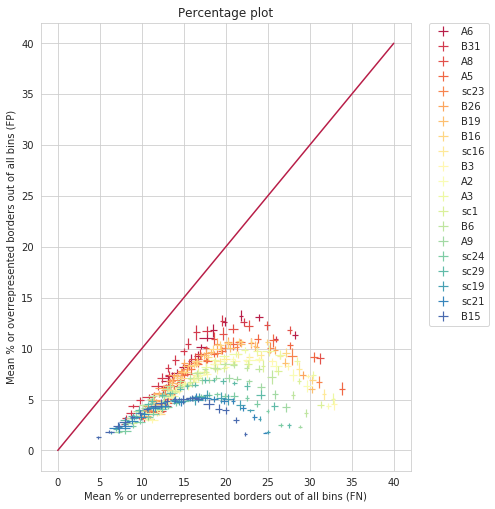

In [831]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp]
    stderr_x = df_perc_under.groupby('perc').std()[exp]
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, caps2ize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or underrepresented borders out of all bins (FN)')
plt.ylabel('Mean % or overrepresented borders out of all bins (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

plt.plot([0,40], [0,40])

Text(0.5,1,'Percentage plot')

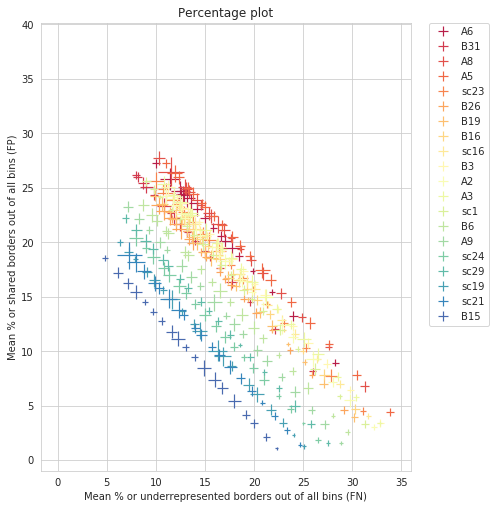

In [792]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc_under.groupby('perc').mean()[exp]
    stderr_x = df_perc_under.groupby('perc').std()[exp]
    means_y  = df_perc.groupby('perc').mean()[exp]
    stderr_y = df_perc.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or underrepresented borders out of all bins (FN)')
plt.ylabel('Mean % or shared borders out of all bins (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])

Text(0.5,1,'Percentage plot')

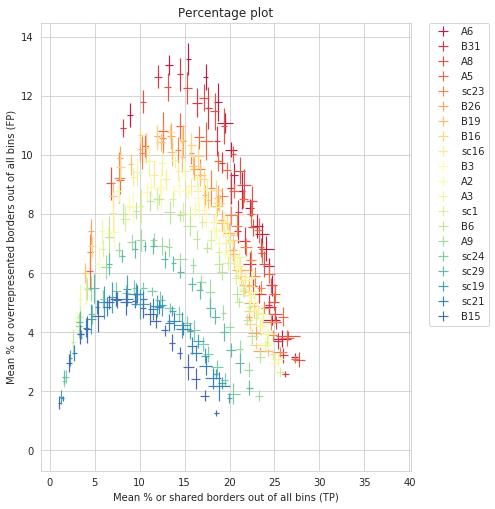

In [793]:
sns.set_palette('Spectral', 20) #husl
plt.figure(figsize=[7,7])
for exp in labels_ordered[2:]:
    means_x  = df_perc.groupby('perc').mean()[exp]
    stderr_x = df_perc.groupby('perc').std()[exp]
    means_y  = df_perc_over.groupby('perc').mean()[exp]
    stderr_y = df_perc_over.groupby('perc').std()[exp]
    plt.errorbar(100*means_x, 100*means_y, label=exp,
                 xerr=100*stderr_x, 
                 yerr=100*stderr_y, 
                elinewidth=1.2, capsize=0, capthick=1.5, linewidth=0)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.xlabel('Mean % or shared borders out of all bins (TP)')
plt.ylabel('Mean % or overrepresented borders out of all bins (FP)')
#plt.xlim([0,100])
plt.tight_layout()
plt.title('Percentage plot')
#plt.ylim([0,1])